### **Estrategia con Etiquetas `-1`**

### **Introducción**
En el análisis inicial de clustering utilizando DBSCAN o HDBSCAN, se observaron puntos etiquetados como `-1`, los cuales representan **outliers** o datos que no pudieron ser asignados a ningún cluster. Aunque estos puntos se consideran ruido dentro del modelo original, contienen información valiosa que puede ser aprovechada mediante un análisis adicional.

Para estos datos etiquetados como `-1`, se plantea una estrategia de clustering secundaria, que combinará características extraídas de imágenes, texto y otros atributos relevantes (como precios, marcas y códigos GTIN) con el objetivo de asignarlos a nuevos clusters de manera más eficiente.

---

### **Estrategia Propuesta**

#### **1. Extracción de Características**
Para analizar los puntos `-1` y asignarlos a nuevos clusters, se utilizarán los siguientes tipos de características:
- **Imágenes**: Usaremos el modelo **CLIP** para generar embeddings de características visuales desde las URL de las imágenes.
- **Texto**: También utilizaremos **CLIP** para extraer embeddings textuales basados en los títulos de los productos, además de incluir los embeddings previamente generados en el archivo Pickle.
- **Atributos Adicionales**:
  - Precios: Serán normalizados utilizando `StandardScaler`.
  - Marcas: Serán codificadas en formato **One-Hot Encoding**.
  - GTIN: Si está disponible, será codificado para mejorar la separación.

---

#### **2. Clustering Secundario con DBSCAN**
Una vez procesadas las características, se realizará un segundo análisis de clustering sobre los puntos `-1` utilizando **DBSCAN**:
- **Ventajas de DBSCAN**:
  - Manejo eficiente de densidades variables.
  - Detección de clusters compactos en datos complejos.
  - Reducción de la complejidad en comparación con HDBSCAN.
- **Parámetros a Configurar**:
  - `eps`: Distancia máxima entre puntos para formar un cluster.
  - `min_samples`: Número mínimo de puntos necesarios para formar un cluster.

---

#### **3. Integración de Resultados**
- Los puntos etiquetados como `-1` en el clustering original serán reclasificados en nuevos clusters.
- Los clusters existentes y los nuevos se integrarán en un único conjunto, con etiquetas actualizadas.

---

#### **4. Visualización y Análisis**
Para evaluar los resultados, se implementarán:
- Visualizaciones en 2D utilizando **UMAP** para mostrar la distribución de los nuevos clusters.
- Métricas de evaluación (como **Silhouette Score** y **Davies-Bouldin Score**) para validar la calidad del nuevo clustering.

---

### **Beneficios de la Estrategia**
1. **Mejora la Cobertura**: Los puntos originalmente marcados como `-1` serán aprovechados, aumentando la cantidad de datos útiles.
2. **Integración de Múltiples Fuentes de Información**: La combinación de características visuales, textuales y numéricas permitirá una segmentación más precisa.
3. **Mayor Flexibilidad**: Usar DBSCAN en esta etapa facilitará el ajuste de parámetros y el análisis de los resultados.


In [37]:
import pandas as pd
df = pd.read_csv('../data/clustering_results/products_title_clustering_20250205_171807.csv')
df_csv = df[df["cluster"]==-1]
df_csv.head()

id                                              title  \
0   MCO1312345739                     Cerca 75km - Ganado - Impulsor   
2    MCO601595467  Limpiador  Electrónico -removedor De Polvo - A...   
3    MCO611865640  Planta Cerca Eléctrica Solar 100km, Incluye Pa...   
12   MCO658922476  Batería Lipo 3.7v 1s 1000mah Nueva Drone Proye...   
16   MCO826585974  Punta Logica Automotriz 6v 12v 24v Probador De...   

                                            thumbnail   price  \
0   http://http2.mlstatic.com/D_926804-MCO70350738...  165000   
2   http://http2.mlstatic.com/D_995727-MCO73203873...   21500   
3   http://http2.mlstatic.com/D_844953-MCO45203598...  690000   
12  http://http2.mlstatic.com/D_877411-MCO47231784...   36550   
16  http://http2.mlstatic.com/D_681123-MCO48067623...   35000   

                    brand                       gtin              brand_std  \
0      CERCAS DEL ORIENTE  000223213232,000055393829     cercas del oriente   
2             ABRO DUSTER                        NaN            abro duster   
3   UNIVERSAL ELECTRÓNICS                        NaN  universal electronics   
12                    NaN                        NaN                    NaN   
16                  Tonic                        NaN                  tonic   

                            gtin_std  \
0   ['000055393829', '000223213232']   
2                                 []   
3                                 []   
12                                []   
16                                []   

                                            title_std  \
0                          cerca 75km ganado impulsor   
2   limpiador electrónico removedor polvo aire com...   
3   planta cerca eléctrica solar 100km incluye pan...   
12  batería lipo 3 7v 1s 1000mah nueva drone proye...   
16  punta logica automotriz 6v 12v 24v probador ci...   

                                      title_std_lemma  price_std  cluster  
0                         cerca 75 km ganado impulsor   165000.0       -1  
2   limpiador electrónico removedor polvo aire com...    21500.0       -1  
3   plantar cerca eléctrico solar 100 km incluir p...   690000.0       -1  
12  batería lipo 3 7v 1s 1000mah nuevo dronir proy...    36550.0       -1  
16  punta logico automotriz 6v 12v 24v probador ci...    35000.0       -1

In [130]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tqdm import tqdm
from itertools import product

# Supongamos que los datos ya están cargados en las siguientes variables
# outliers: DataFrame con los puntos etiquetados como -1
# image_features, price_features, brand_encoded, gtin_encoded: Características preprocesadas

# Definir las combinaciones de características (images siempre incluido)
def combine_features(use_embeddings, use_prices, use_brands, use_gtin):
    features = []
    # Las imágenes siempre están incluidas
    features.append(image_features)
    if use_embeddings:
        features.append(np.array(outliers['embeddings_title_std_lemma'].tolist()))
    if use_prices:
        features.append(price_features)
    if use_brands:
        features.append(brand_encoded)
    if use_gtin:
        features.append(gtin_encoded)
    
    return np.hstack(features)

# Parámetros de Grid Search
eps_values = [3.6,3.7, 3.8, 3.9, 4, 4.1, 4.2, 4.3,4.4]
min_samples_values = [2, 3, 4]
# Combinaciones de características (siempre incluyen imágenes)
feature_combinations = list(product([True, False], repeat=4))  # Para embeddings, prices, brands y gtin

# Crear un DataFrame para almacenar los resultados
results = []

# Realizar el Grid Search
for use_embeddings, use_prices, use_brands, use_gtin in tqdm(feature_combinations, desc="Combinaciones de características"):
    # Combinar características
    X_features = combine_features(use_embeddings, use_prices, use_brands, use_gtin)
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            try:
                # Aplicar DBSCAN
                dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
                labels = dbscan.fit_predict(X_features)

                # Filtrar solo clusters válidos
                valid_points = labels != -1
                X_valid = X_features[valid_points]
                labels_valid = labels[valid_points]
                
                if len(set(labels_valid)) > 1:  # Al menos 2 clusters válidos
                    silhouette_avg = silhouette_score(X_valid, labels_valid, metric='euclidean')
                    davies_bouldin = davies_bouldin_score(X_valid, labels_valid)
                else:
                    silhouette_avg = None
                    davies_bouldin = None
                
                # Porcentaje de ruido
                noise_ratio = (labels == -1).sum() / len(labels)
                
                # Guardar resultados solo si el Noise Ratio >= 0.8
                if noise_ratio <= 0.8:
                    results.append({
                        'use_embeddings': use_embeddings,
                        'use_prices': use_prices,
                        'use_brands': use_brands,
                        'use_gtin': use_gtin,
                        'eps': eps,
                        'min_samples': min_samples,
                        'silhouette_score': silhouette_avg,
                        'davies_bouldin_score': davies_bouldin,
                        'noise_ratio': noise_ratio
                    })
            except Exception as e:
                print(f"Error en la combinación: embeddings={use_embeddings}, prices={use_prices}, brands={use_brands}, gtin={use_gtin}, eps={eps}, min_samples={min_samples}\n{e}")

# Crear un DataFrame con los resultados
results_df = pd.DataFrame(results)

# Mostrar las mejores combinaciones ordenadas por Silhouette Score
best_results = results_df.sort_values(by='silhouette_score', ascending=False).head(10)
print("\nMejores combinaciones de parámetros y características con Noise Ratio <= 0.8:")
best_results




Combinaciones de características: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


Mejores combinaciones de parámetros y características con Noise Ratio <= 0.8:


use_embeddings  use_prices  use_brands  use_gtin  eps  min_samples  \
28           False        True        True     False  4.0            2   
37           False        True       False     False  4.0            2   
46           False       False        True     False  4.0            2   
55           False       False       False     False  4.0            2   
33           False        True       False      True  4.1            2   
24           False        True        True      True  4.1            2   
29           False        True        True     False  4.1            2   
38           False        True       False     False  4.1            2   
42           False       False        True      True  4.1            2   
51           False       False       False      True  4.1            2   

    silhouette_score  davies_bouldin_score  noise_ratio  
28          0.506509              0.741442     0.799423  
37          0.506509              0.741442     0.799423  
46          0.499009              0.778329     0.796537  
55          0.499009              0.778329     0.796537  
33          0.492048              0.739718     0.796537  
24          0.492048              0.739718     0.796537  
29          0.483817              0.781638     0.787879  
38          0.483817              0.781638     0.787879  
42          0.481188              0.781993     0.790765  
51          0.481188              0.781993     0.790765


Aplicando DBSCAN...

Silhouette Score (nuevos clusters): 0.6565
Davies-Bouldin Score (nuevos clusters): 0.7414

Número de outliers detectados: 554
Porcentaje de ruido: 79.94%

Reduciendo dimensiones con UMAP para visualización...


c:\Users\USER\miniconda3\envs\meli_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\USER\miniconda3\envs\meli_env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


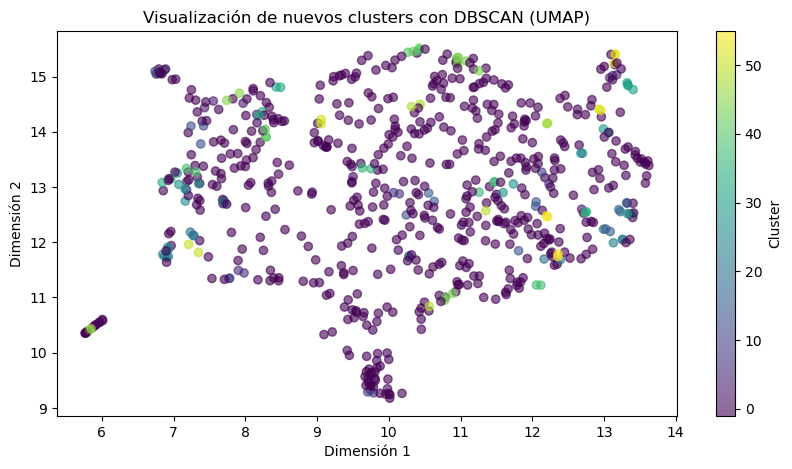

In [135]:
# Combinar todas las características (asegurando que estén correctamente preprocesadas)
X_combined_outliers = np.hstack((
    # np.array(outliers['embeddings_title_std_lemma'].tolist()),  # Embeddings de OpenAI (opcional)
    image_features,
    price_features,
    brand_encoded,
    # gtin_encoded
))

# Aplicar DBSCAN
print("\nAplicando DBSCAN...")
dbscan = DBSCAN(eps=4, min_samples=2, metric='euclidean')
new_labels = dbscan.fit_predict(X_combined_outliers)

# Agregar nuevas etiquetas de cluster
outliers['new_cluster'] = new_labels

# Calcular métricas de evaluación
valid_points = new_labels != -1
X_valid = X_combined_outliers[valid_points]
labels_valid = new_labels[valid_points]

if len(set(labels_valid)) > 1:
    silhouette_avg = silhouette_score(X_valid, labels_valid, metric='cosine')
    davies_bouldin = davies_bouldin_score(X_valid, labels_valid)
    print(f"\nSilhouette Score (nuevos clusters): {silhouette_avg:.4f}")
    print(f"Davies-Bouldin Score (nuevos clusters): {davies_bouldin:.4f}")
else:
    print("\nNo se pueden calcular métricas debido a un número insuficiente de clusters.")

# Calcular número de outliers y porcentaje de ruido
num_outliers = (new_labels == -1).sum()
total_points = len(new_labels)
noise_ratio = num_outliers / total_points
print(f"\nNúmero de outliers detectados: {num_outliers}")
print(f"Porcentaje de ruido: {noise_ratio:.2%}")

# Reducir dimensiones con UMAP
print("\nReduciendo dimensiones con UMAP para visualización...")
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap_2d = umap_reducer.fit_transform(X_combined_outliers)

# Visualización
plt.figure(figsize=(10, 5))
scatter = plt.scatter(
    X_umap_2d[:, 0],
    X_umap_2d[:, 1],
    c=new_labels,
    cmap='viridis',
    alpha=0.6
)
plt.colorbar(scatter, label="Cluster")
plt.title("Visualización de nuevos clusters con DBSCAN (UMAP)")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")
plt.grid(False)
plt.show()


60 Clusters con más productos:
new_cluster
-1     554
 24      6
 11      5
 44      5
 3       4
 31      4
 16      3
 4       3
 0       3
 17      3
 23      3
 43      3
 53      3
 26      3
 12      3
 8       3
 20      3
 37      3
 41      3
 7       2
 2       2
 1       2
 6       2
 5       2
 9       2
 22      2
 21      2
 18      2
 19      2
 10      2
 13      2
 14      2
 15      2
 30      2
 32      2
 34      2
 33      2
 27      2
 28      2
 29      2
 25      2
 39      2
 38      2
 36      2
 35      2
 42      2
 45      2
 46      2
 40      2
 47      2
 48      2
 50      2
 49      2
 51      2
 52      2
 54      2
 55      2
Name: count, dtype: int64

Cluster -1 - Mostrando 35 de 554 productos:


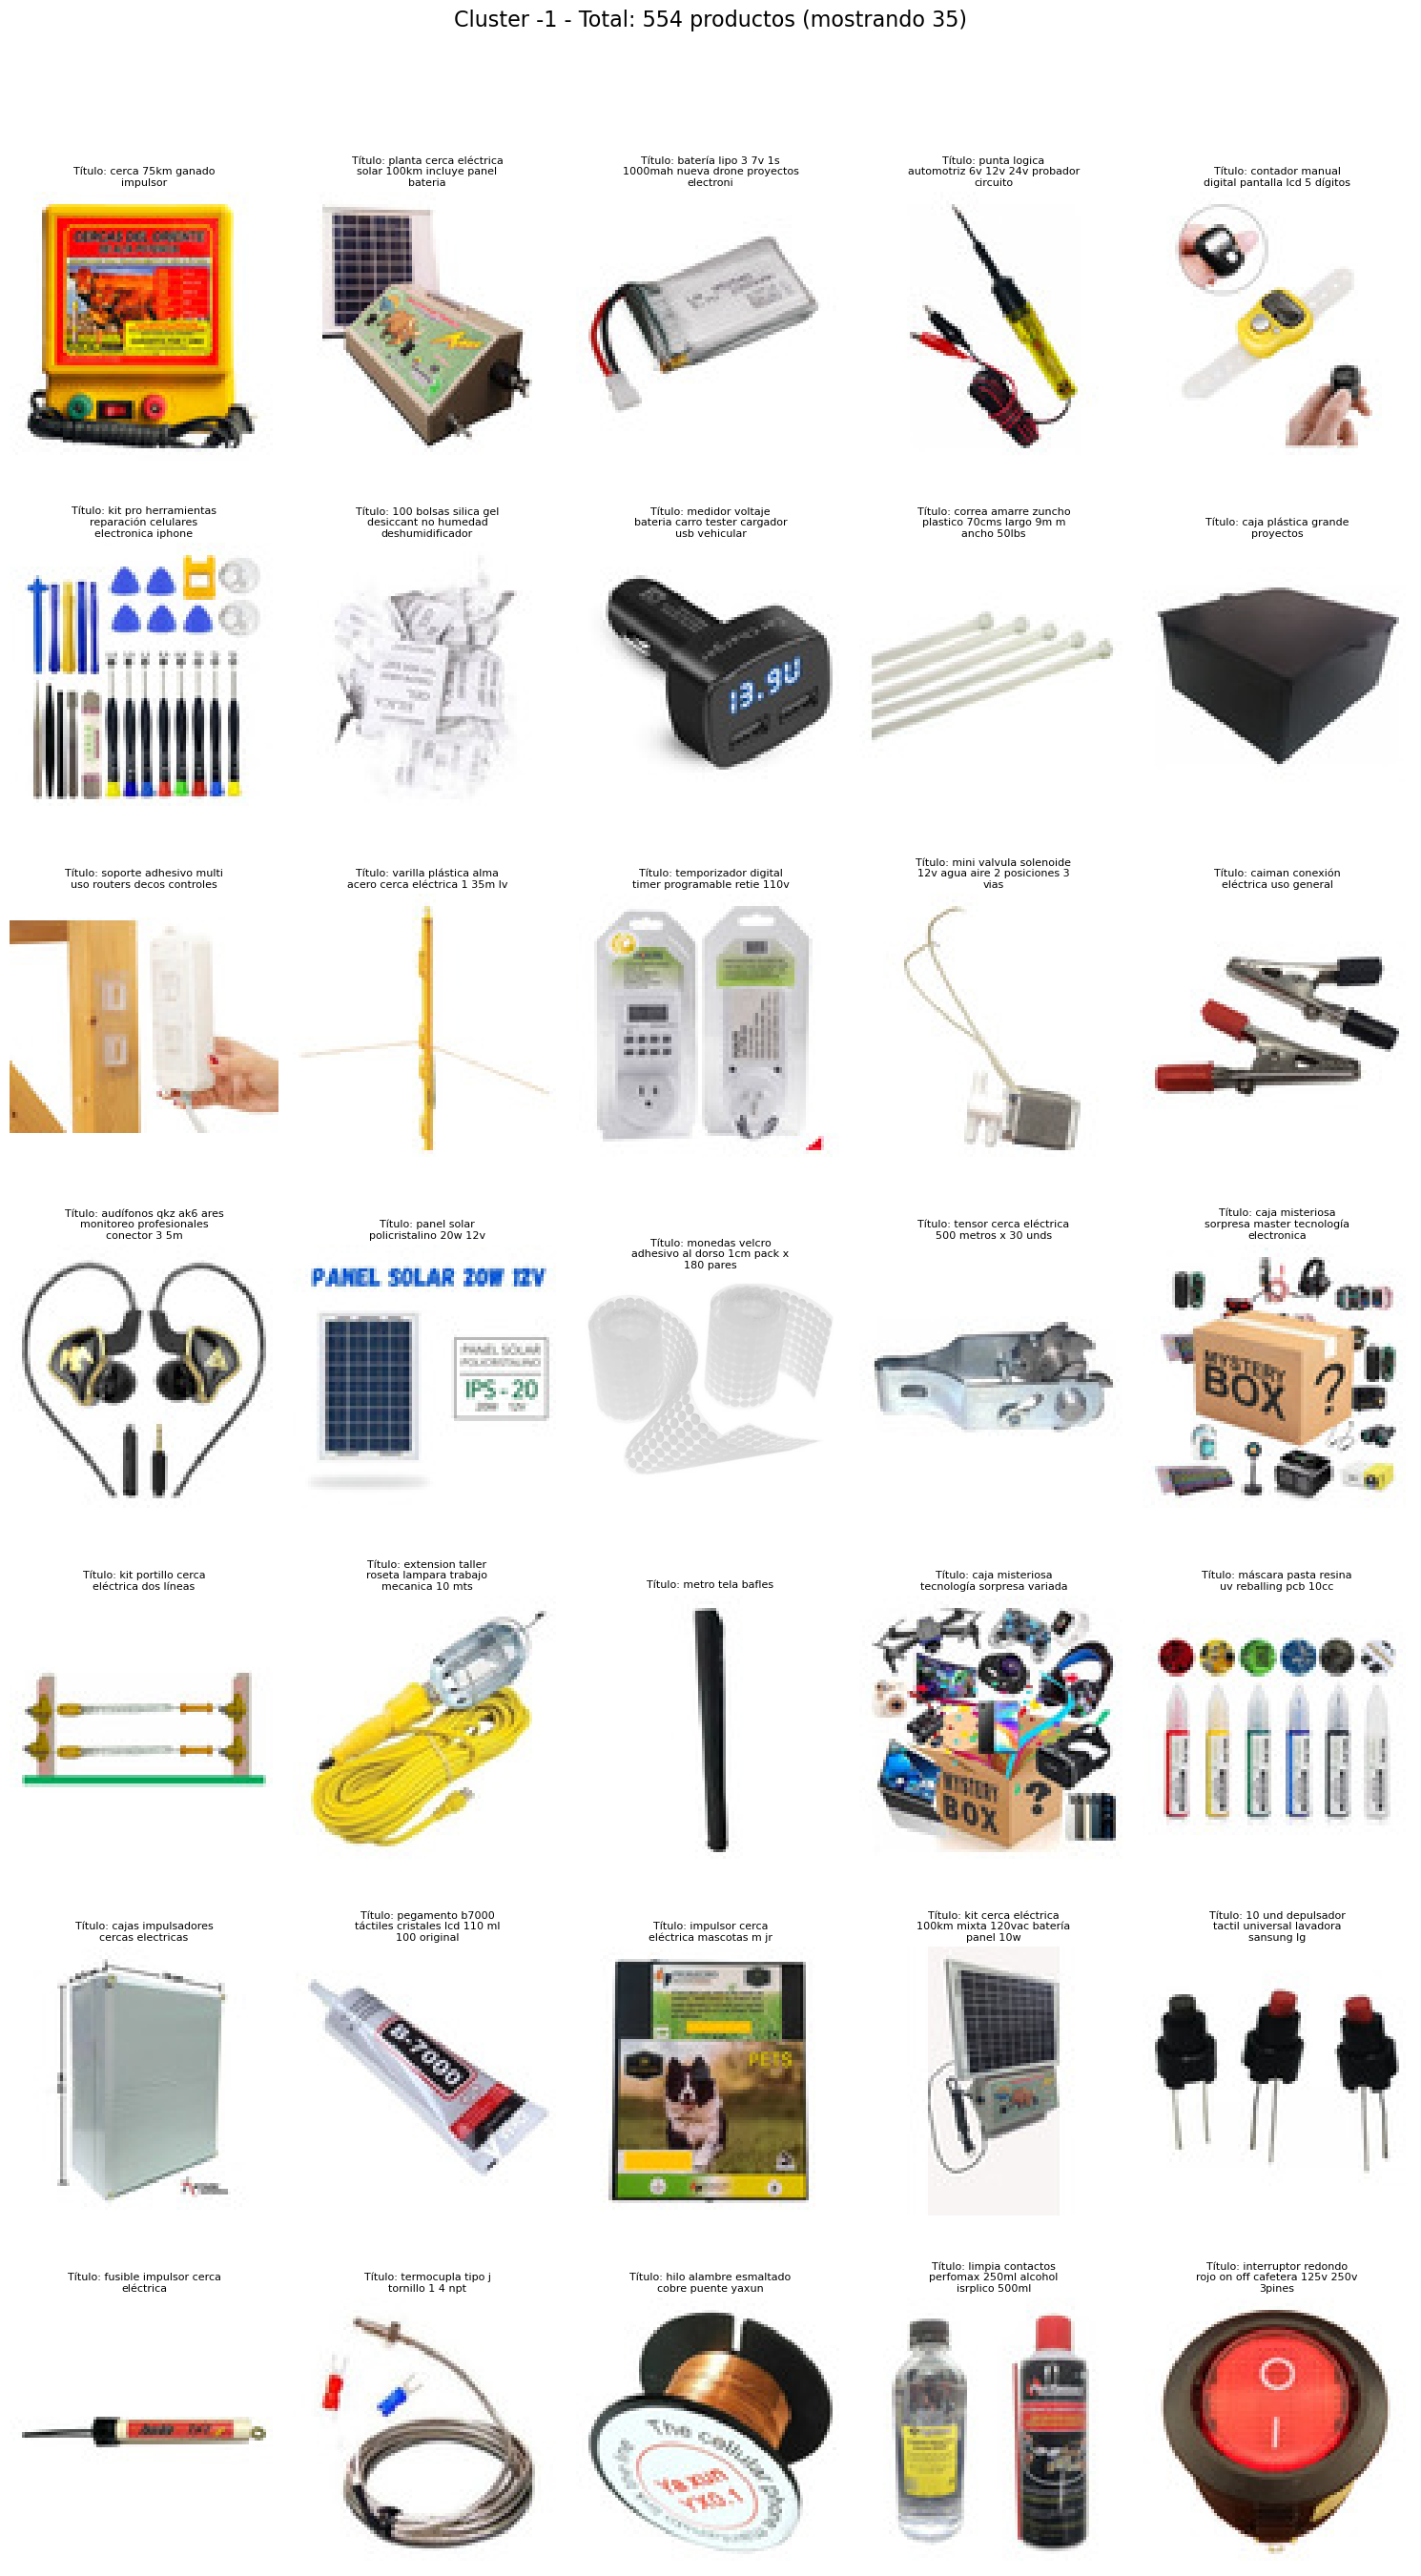


Cluster 24 - Mostrando 6 de 6 productos:


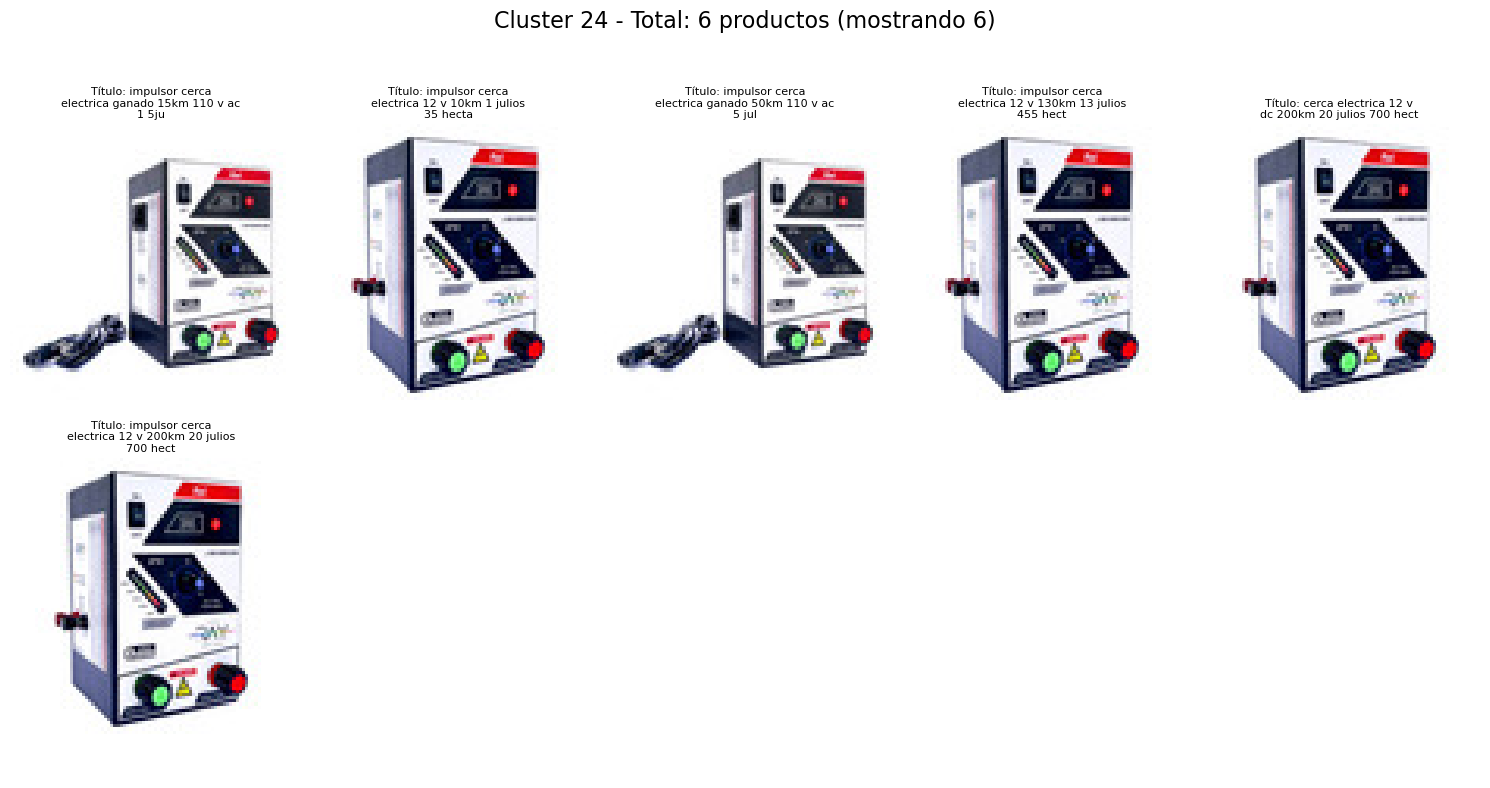


Cluster 11 - Mostrando 5 de 5 productos:


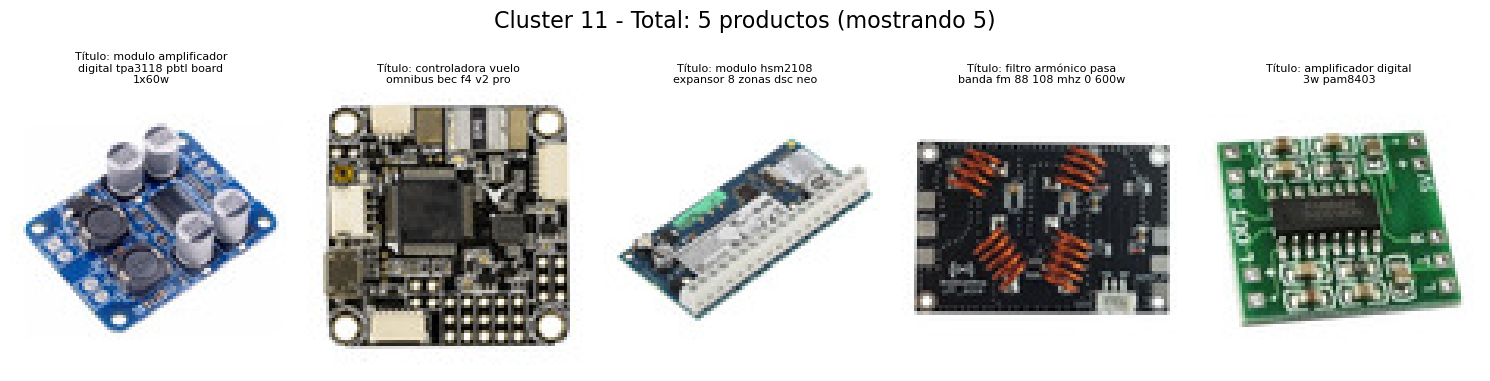


Cluster 44 - Mostrando 5 de 5 productos:


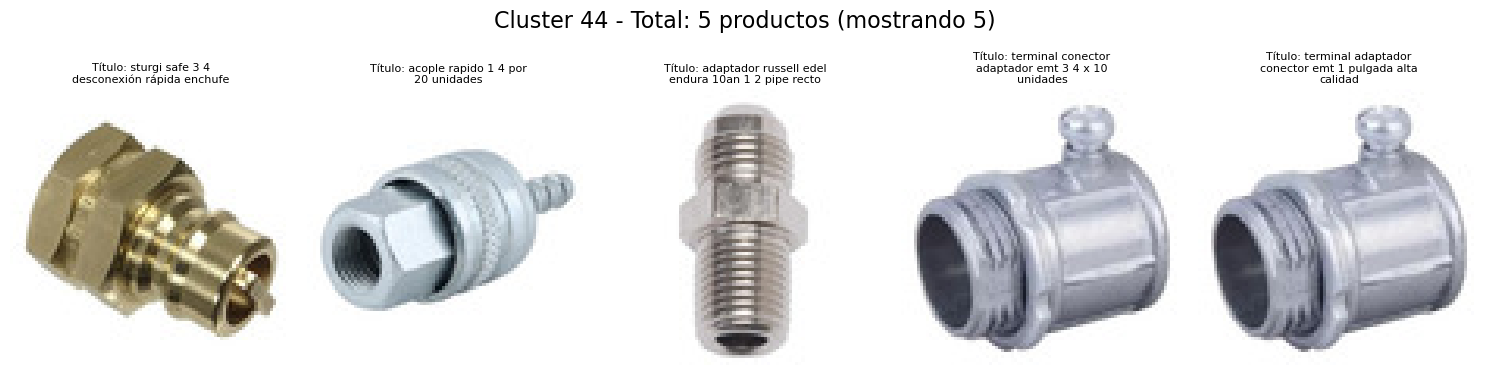


Cluster 3 - Mostrando 4 de 4 productos:


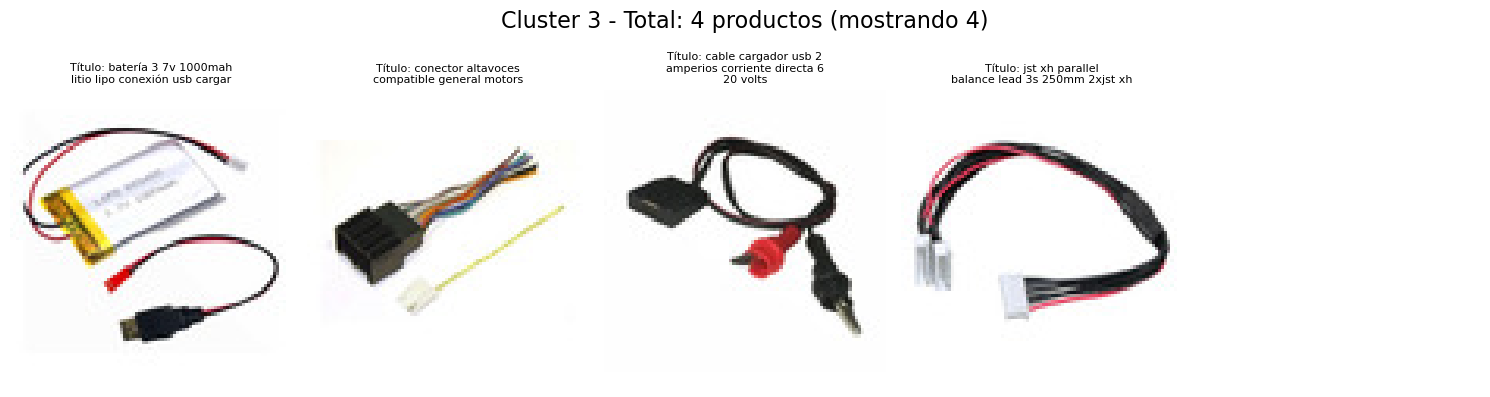


Cluster 31 - Mostrando 4 de 4 productos:


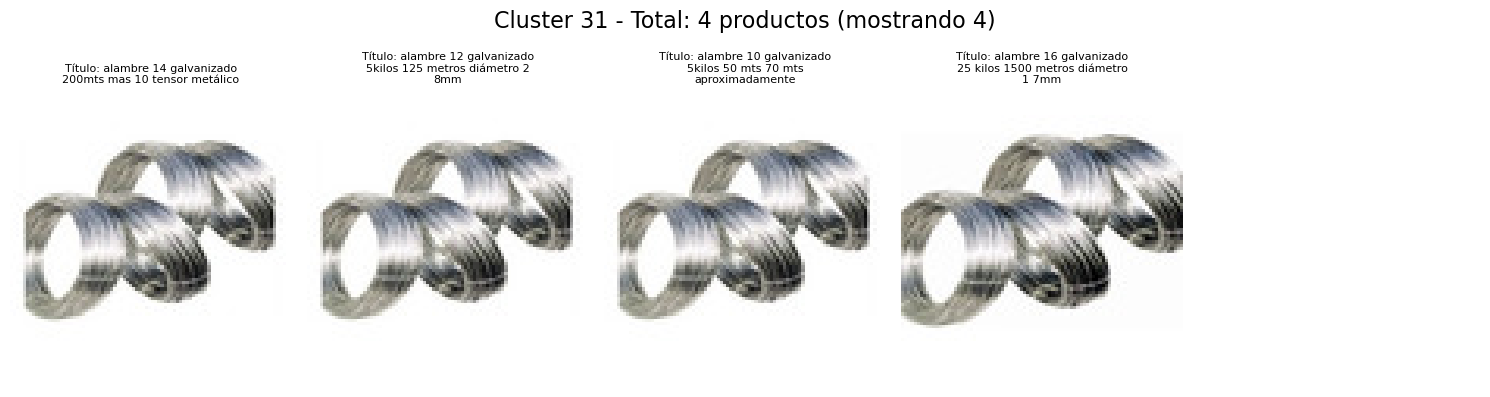


Cluster 16 - Mostrando 3 de 3 productos:


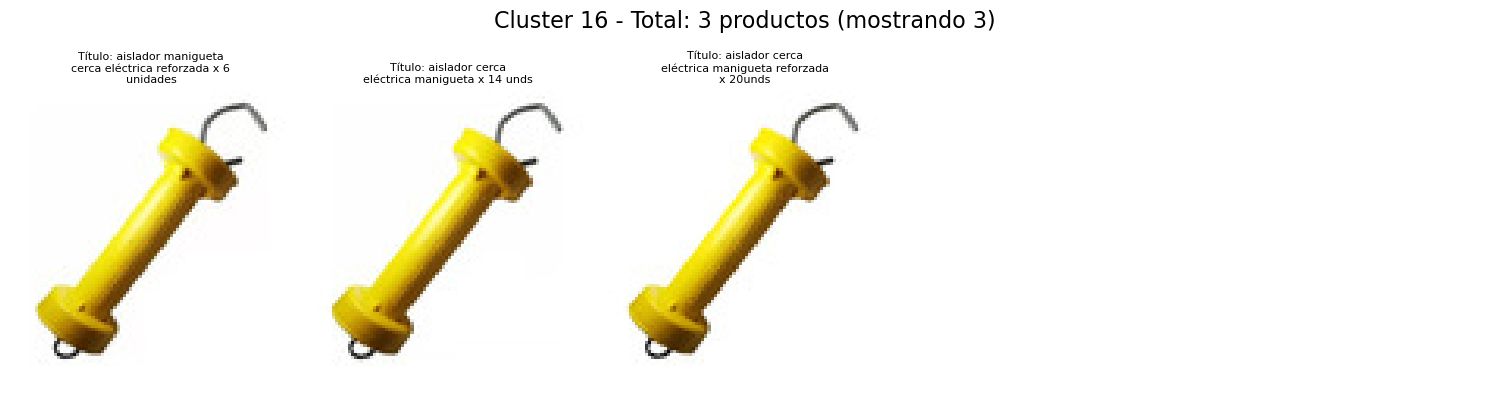


Cluster 4 - Mostrando 3 de 3 productos:


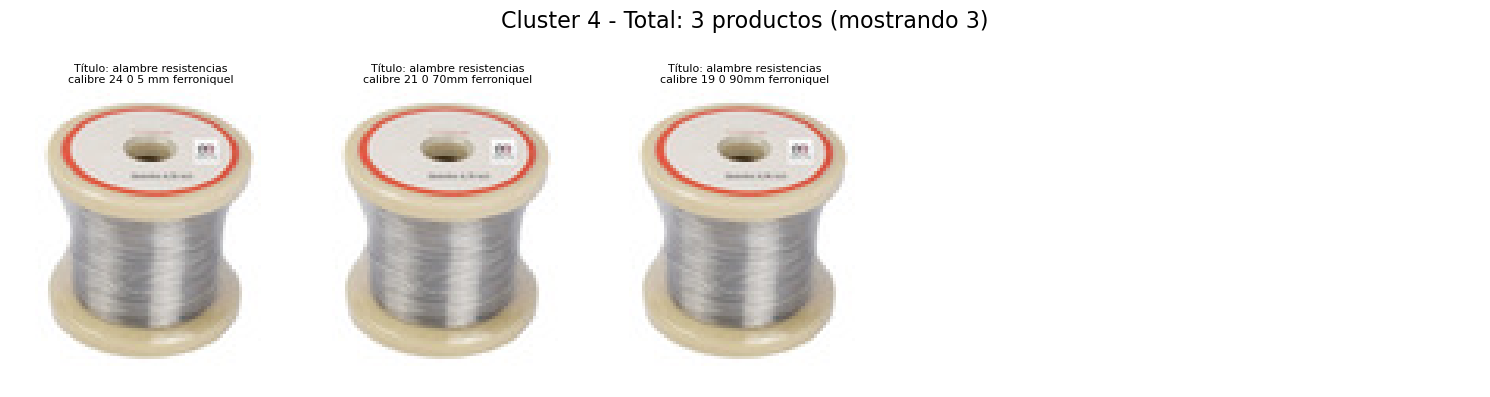


Cluster 0 - Mostrando 3 de 3 productos:


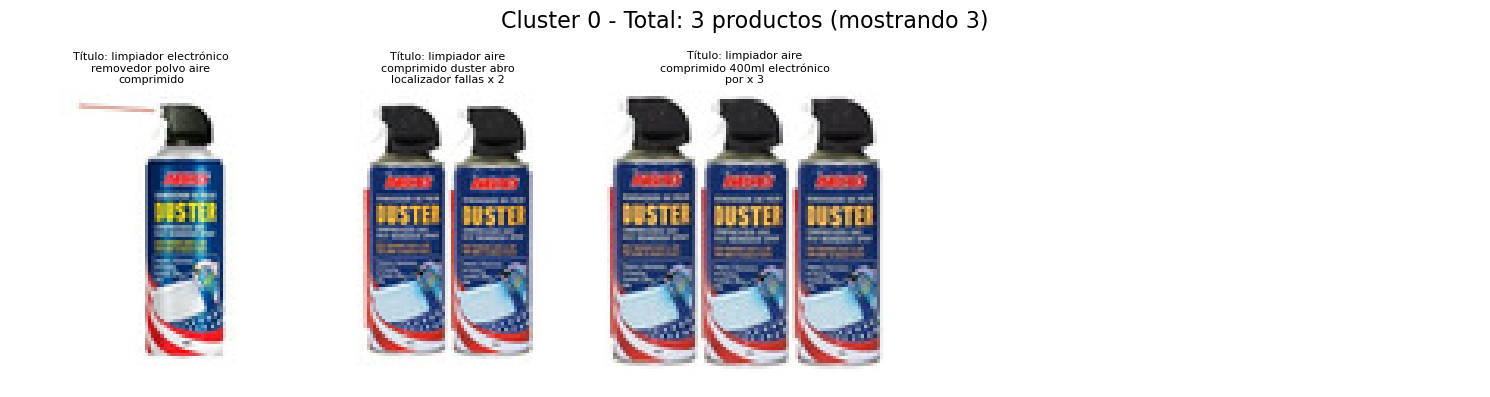


Cluster 17 - Mostrando 3 de 3 productos:


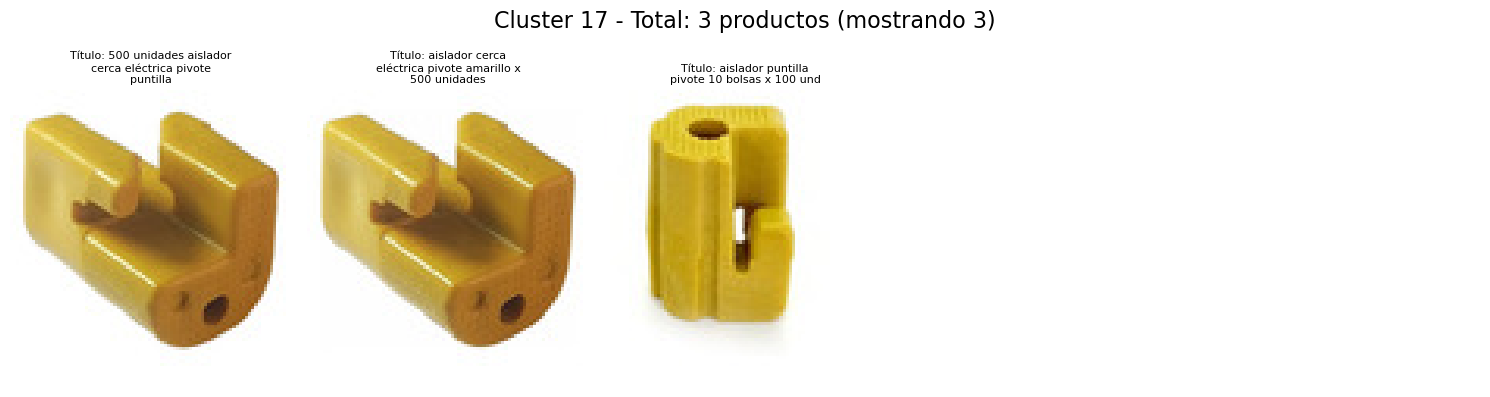


Cluster 23 - Mostrando 3 de 3 productos:


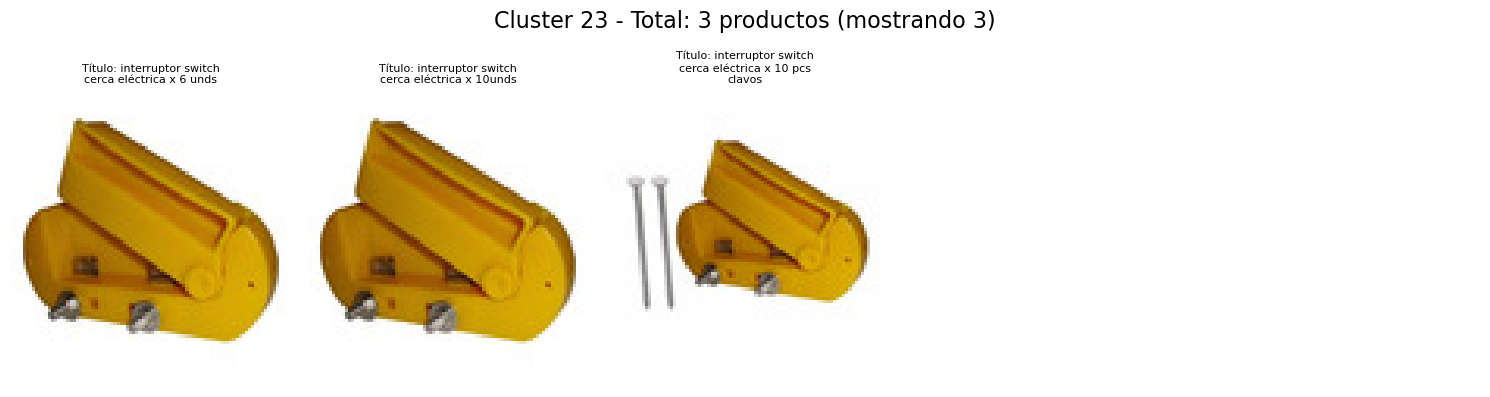


Cluster 43 - Mostrando 3 de 3 productos:


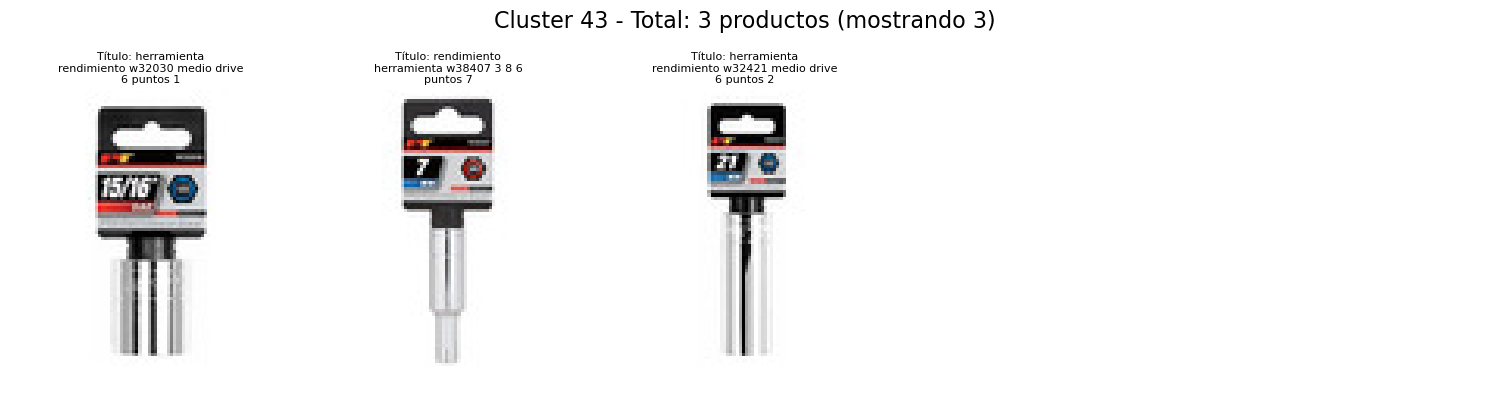


Cluster 53 - Mostrando 3 de 3 productos:


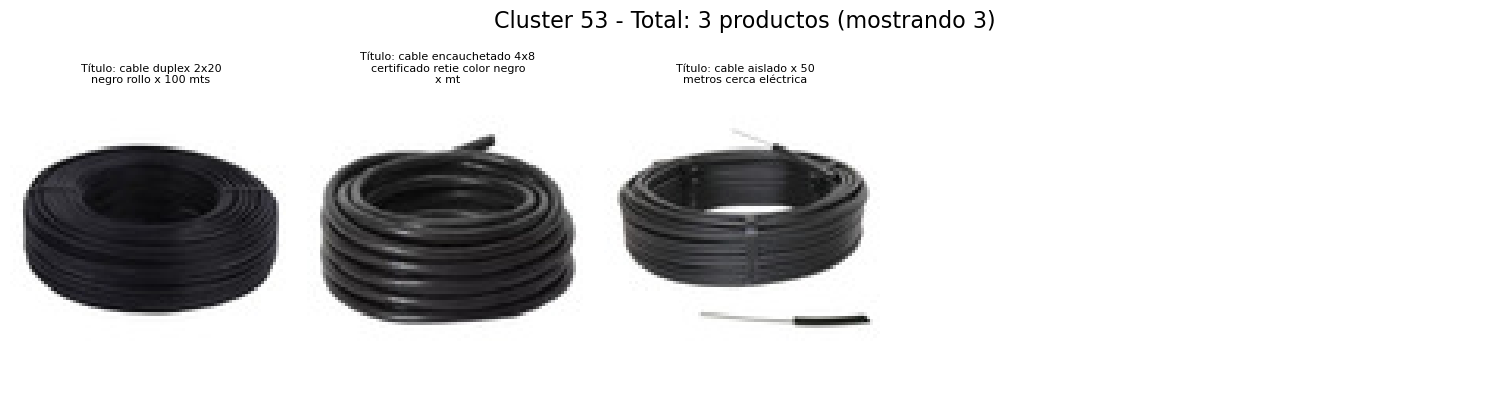


Cluster 26 - Mostrando 3 de 3 productos:


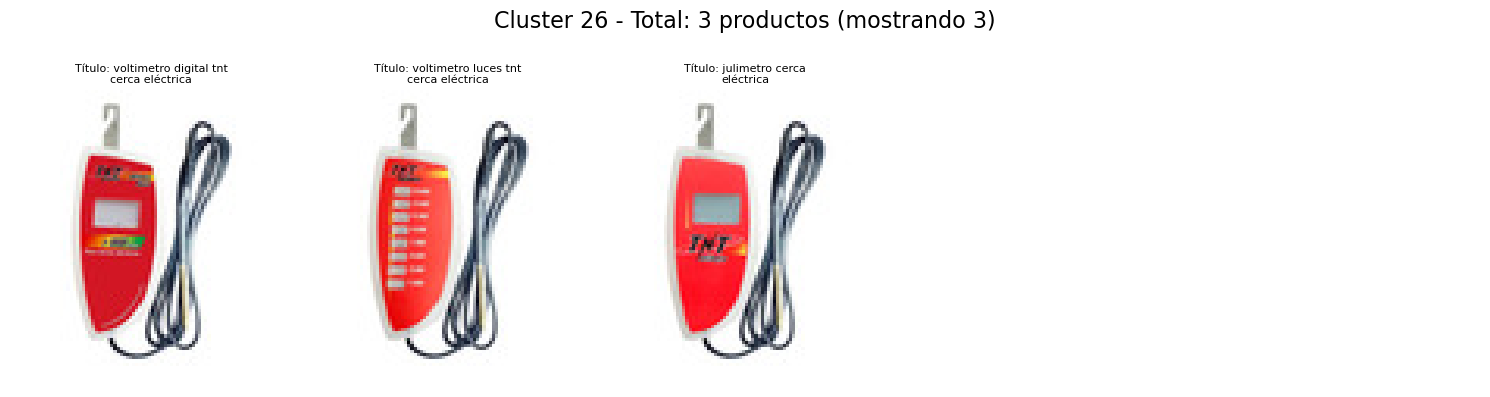


Cluster 12 - Mostrando 3 de 3 productos:


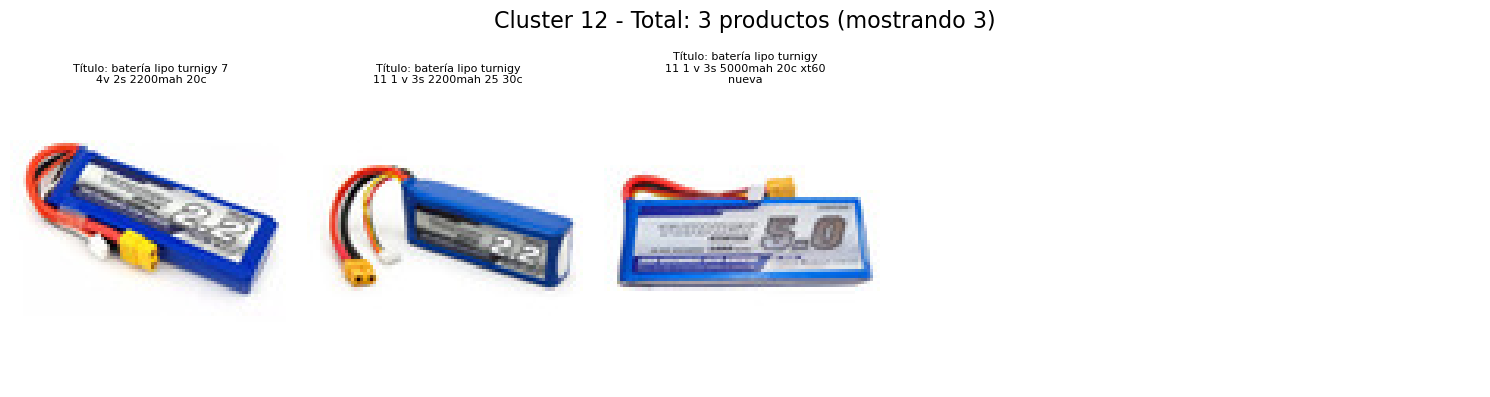


Cluster 8 - Mostrando 3 de 3 productos:


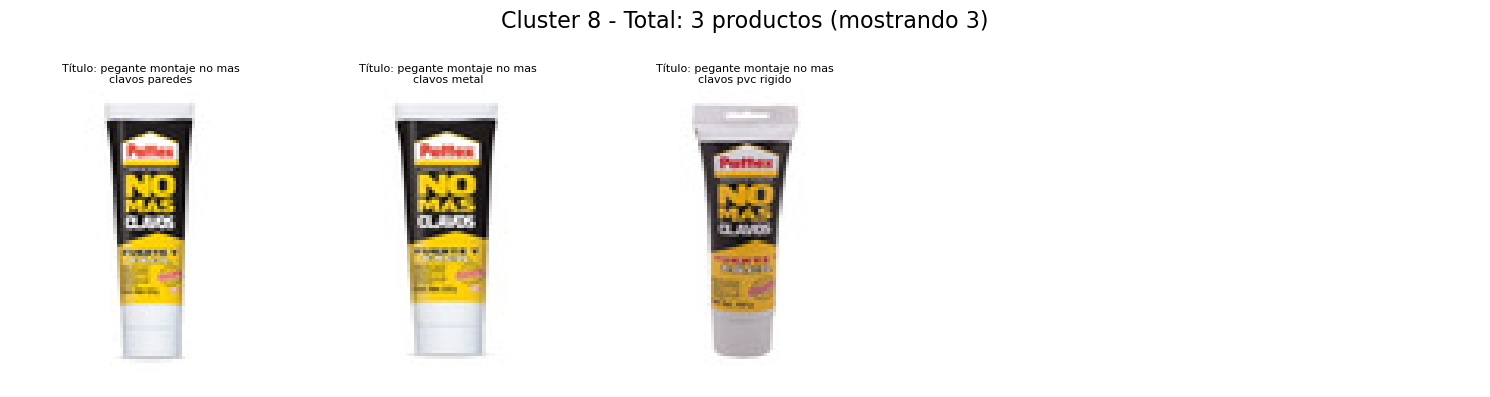


Cluster 20 - Mostrando 3 de 3 productos:


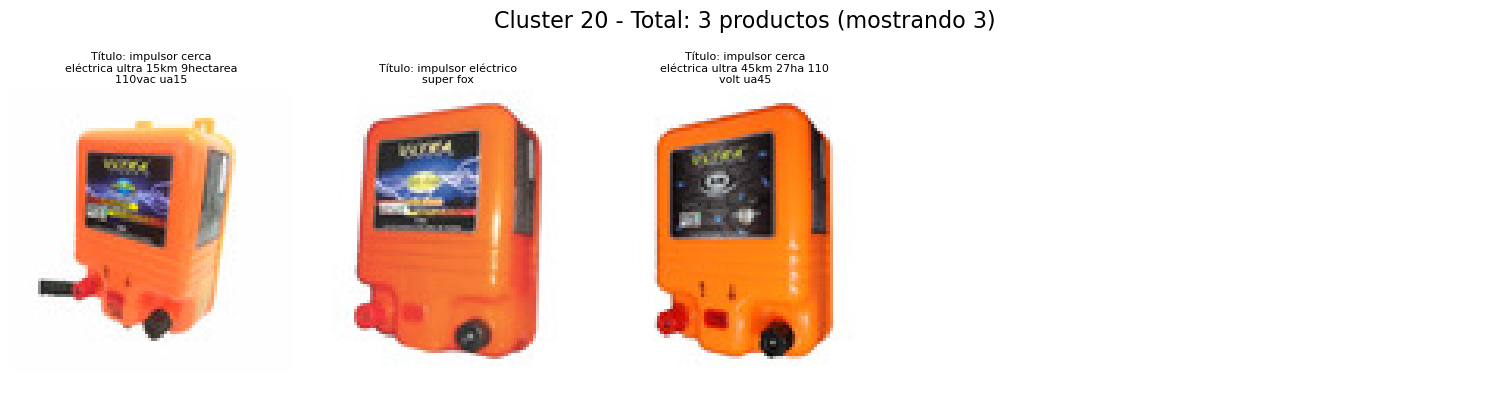


Cluster 37 - Mostrando 3 de 3 productos:


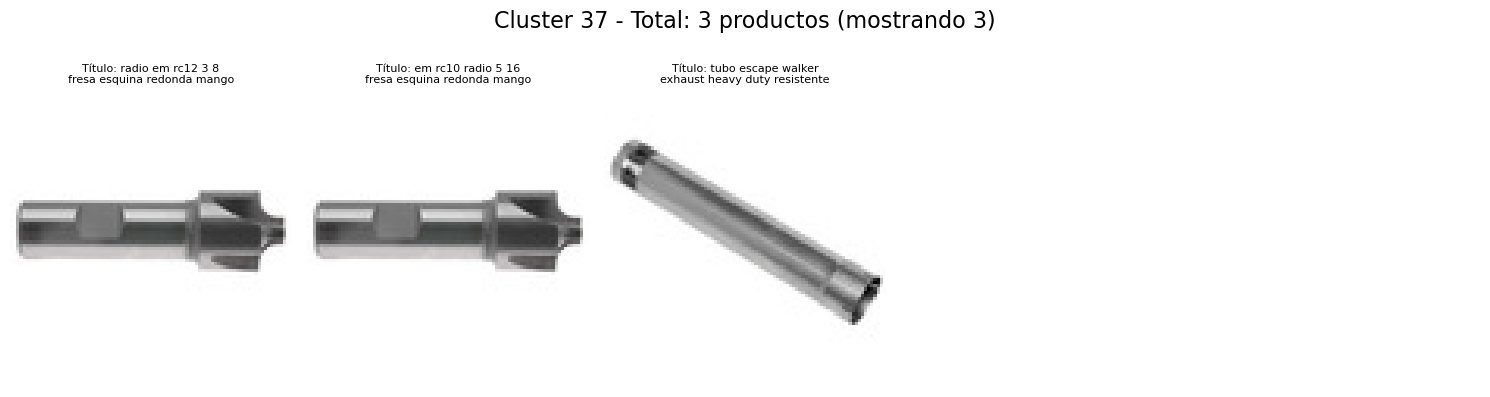


Cluster 41 - Mostrando 3 de 3 productos:


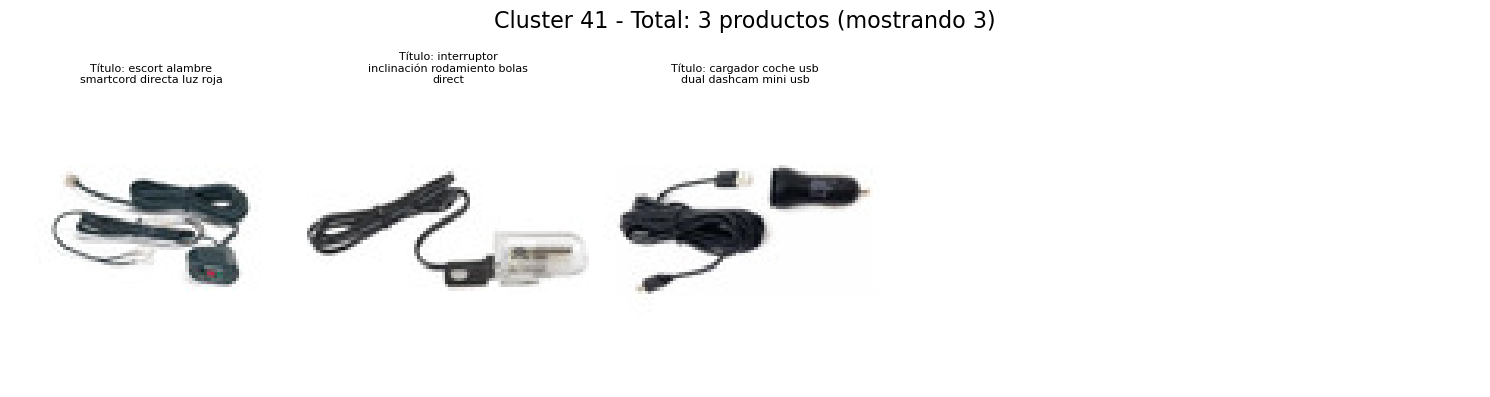


Cluster 7 - Mostrando 2 de 2 productos:


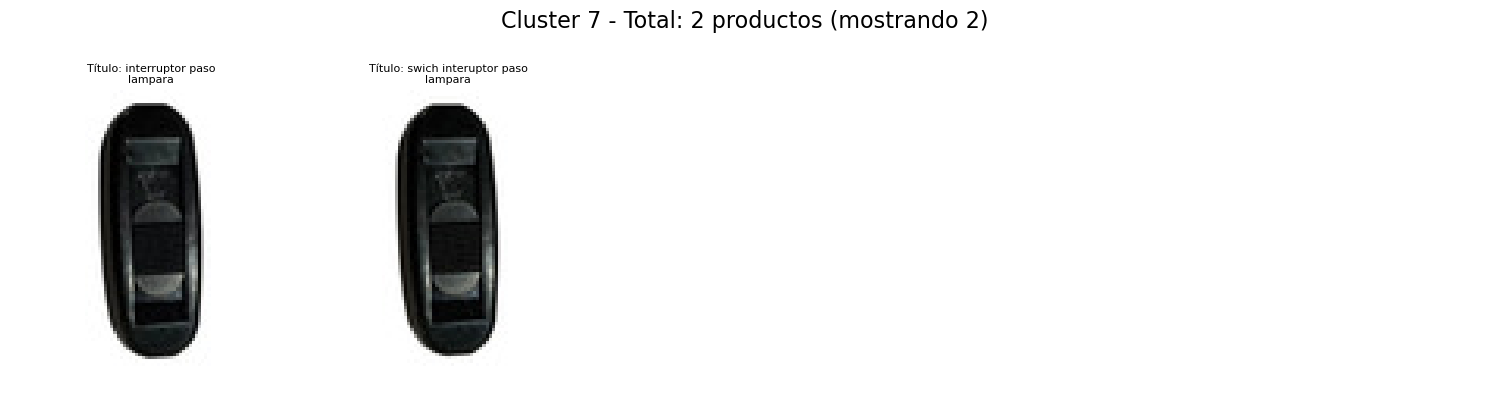


Cluster 2 - Mostrando 2 de 2 productos:


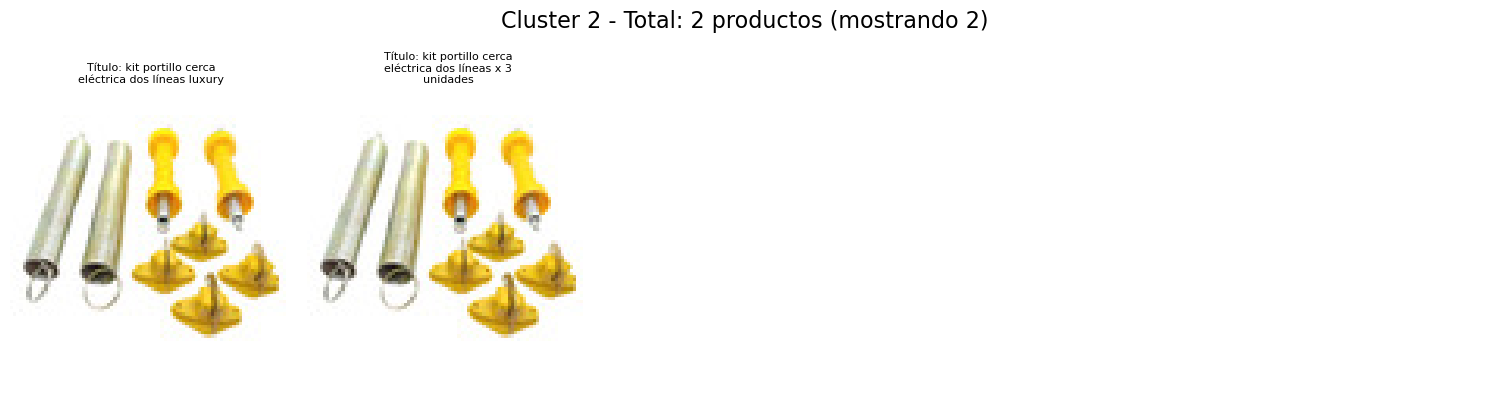


Cluster 1 - Mostrando 2 de 2 productos:


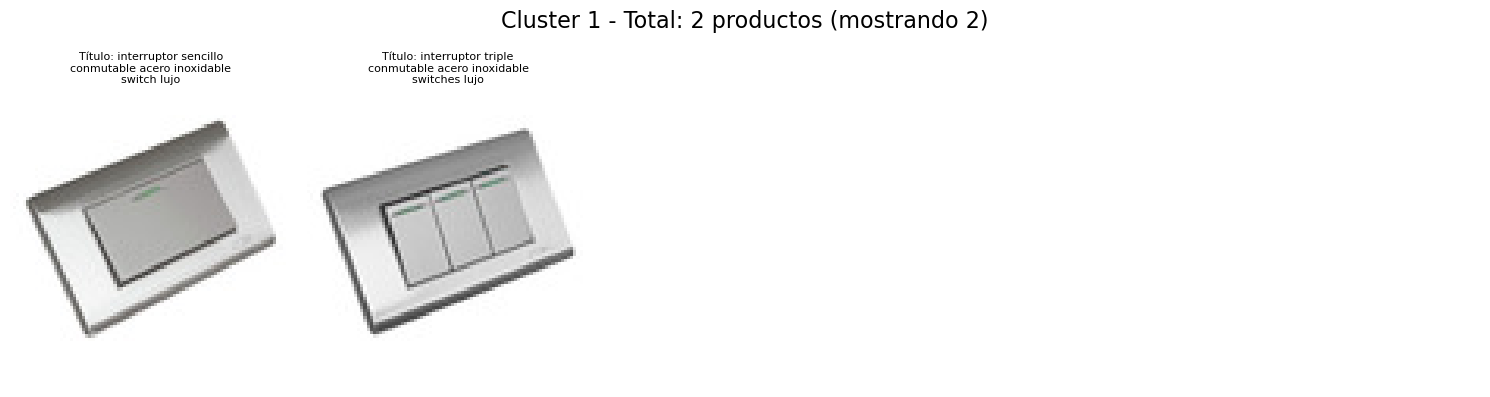


Cluster 6 - Mostrando 2 de 2 productos:


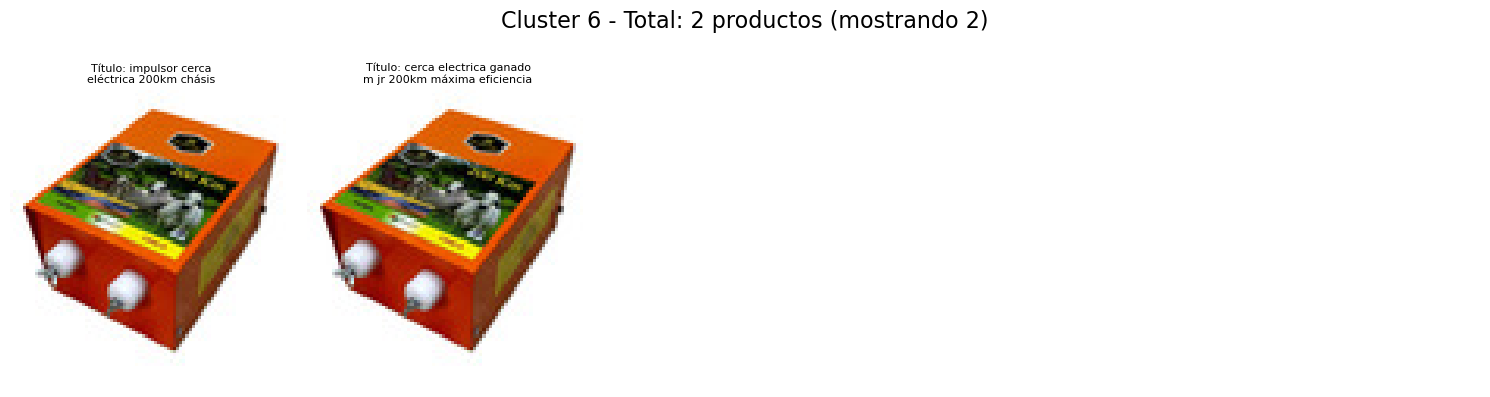


Cluster 5 - Mostrando 2 de 2 productos:


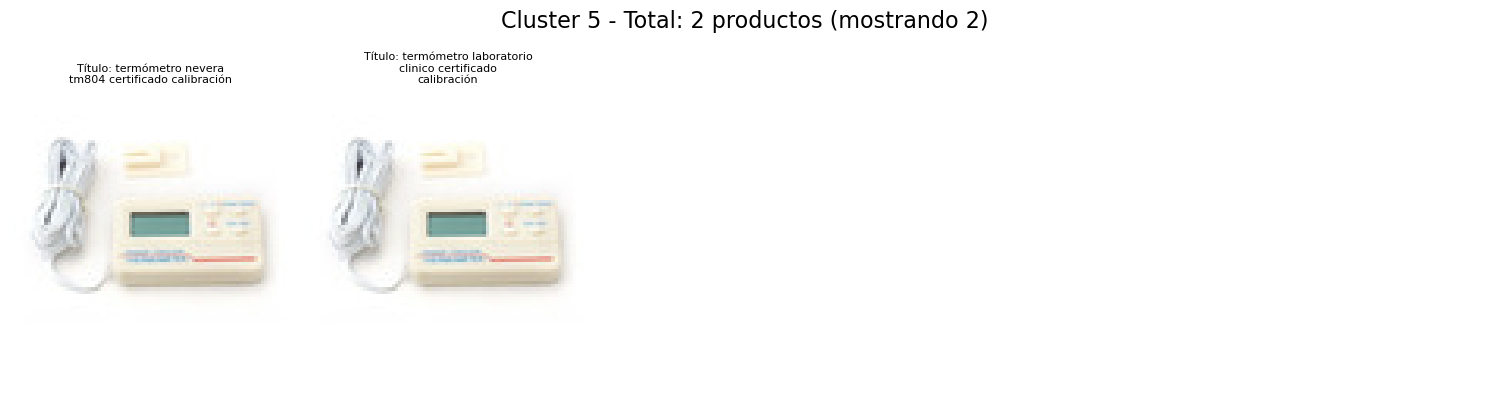


Cluster 9 - Mostrando 2 de 2 productos:


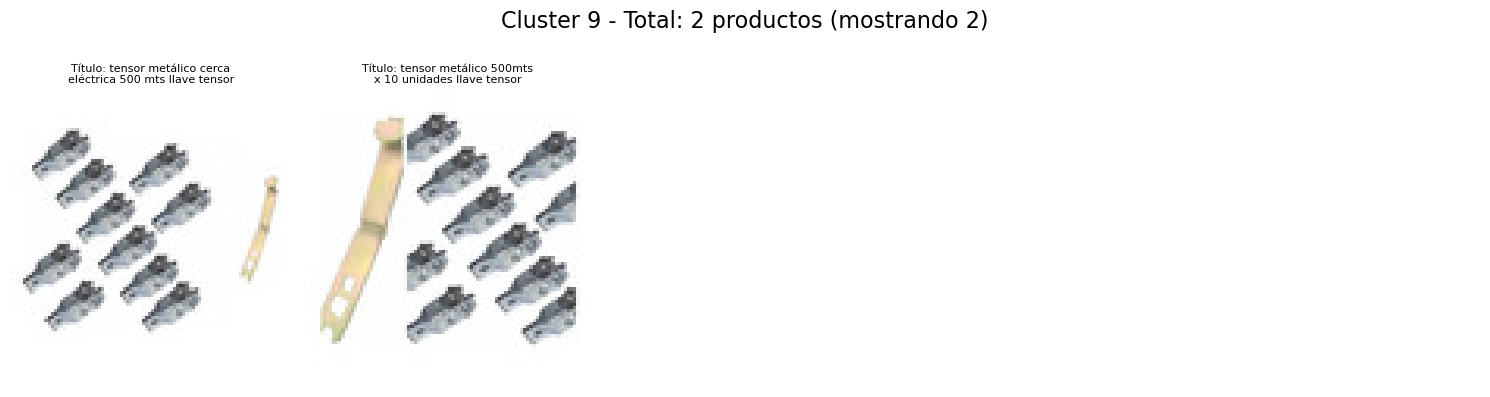


Cluster 22 - Mostrando 2 de 2 productos:


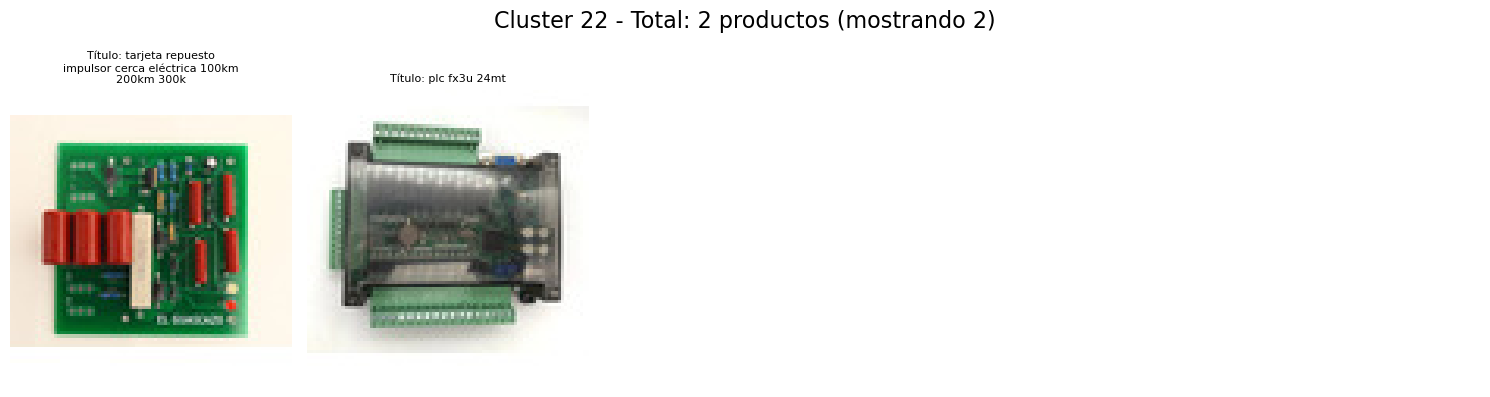


Cluster 21 - Mostrando 2 de 2 productos:


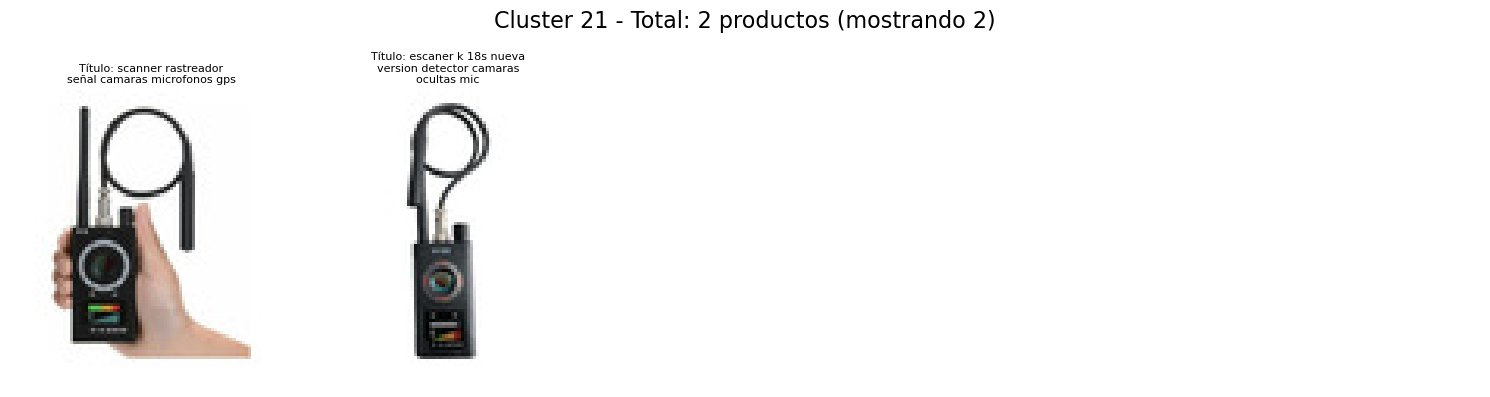


Cluster 18 - Mostrando 2 de 2 productos:


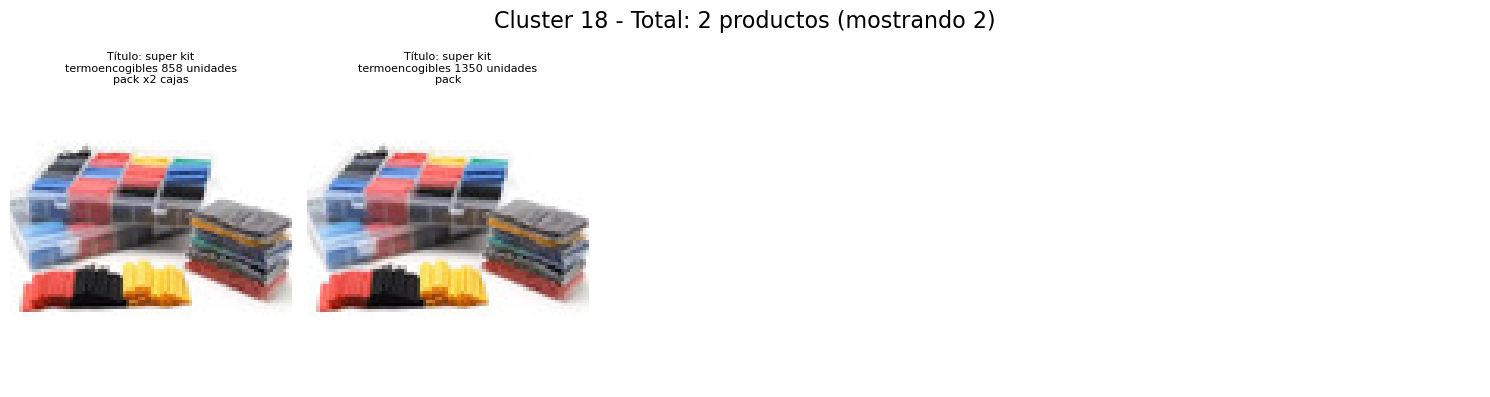


Cluster 19 - Mostrando 2 de 2 productos:


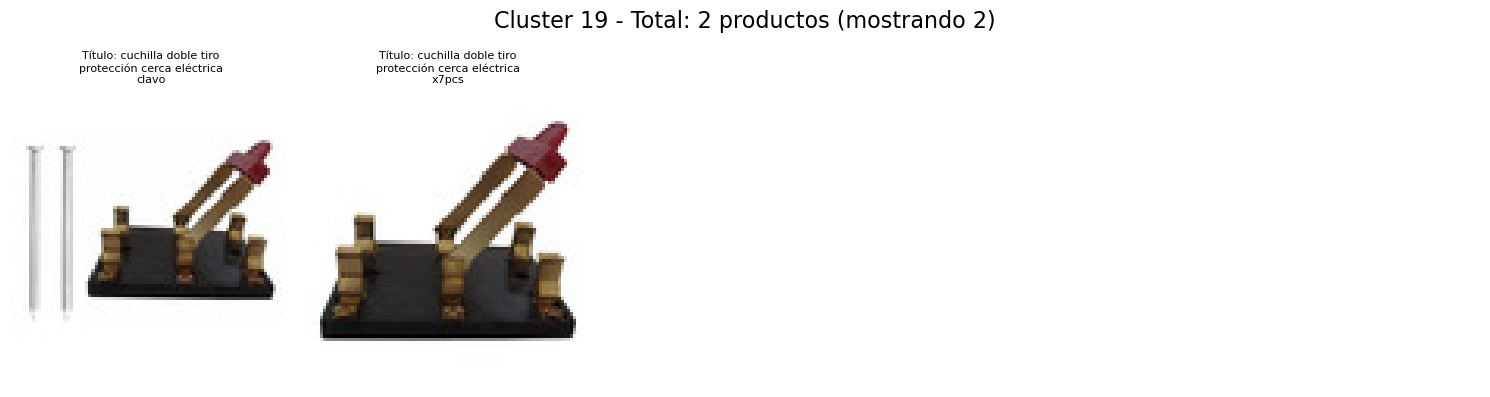


Cluster 10 - Mostrando 2 de 2 productos:


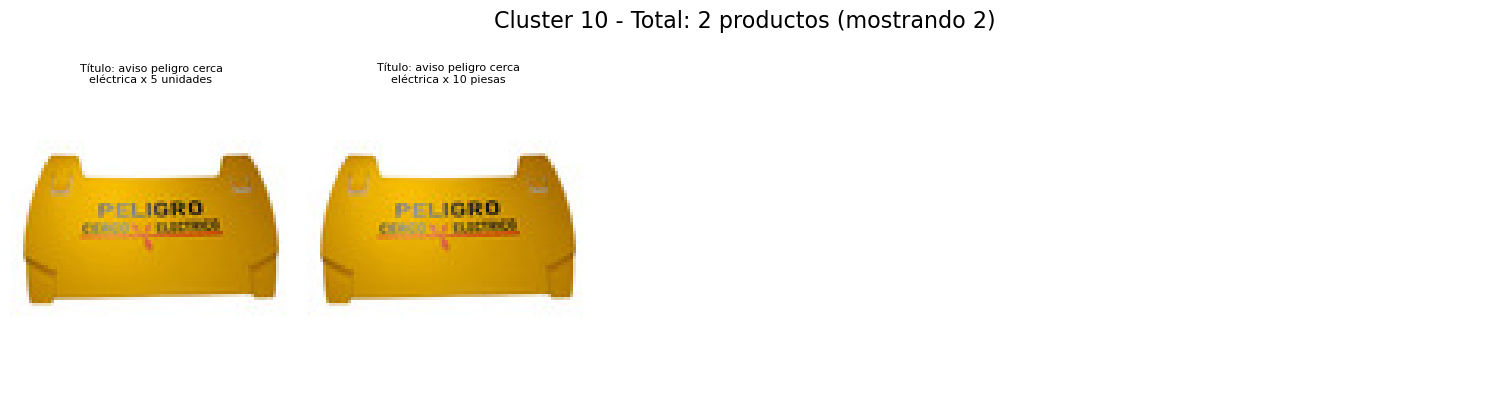


Cluster 13 - Mostrando 2 de 2 productos:


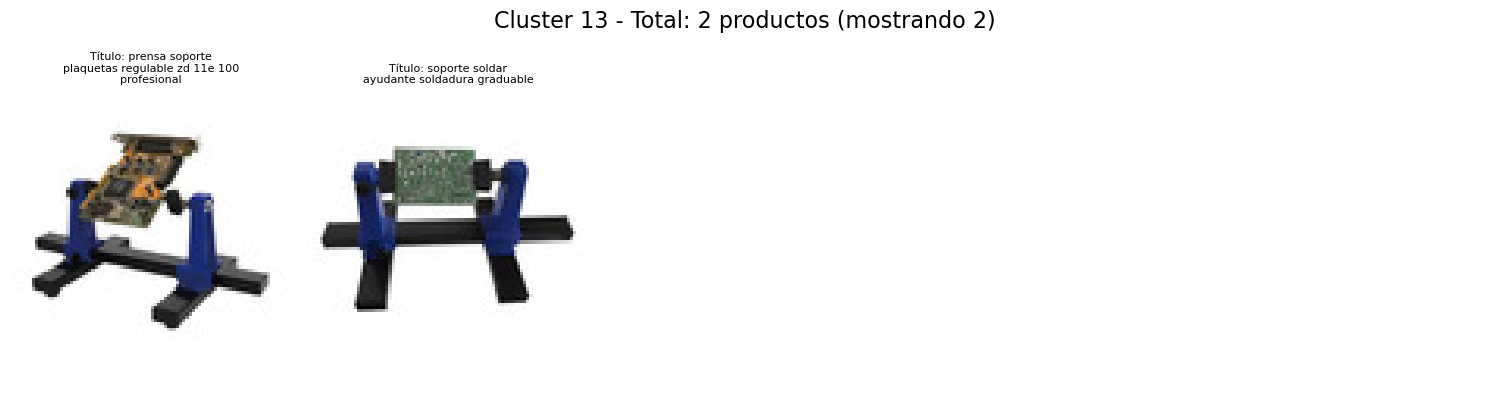


Cluster 14 - Mostrando 2 de 2 productos:


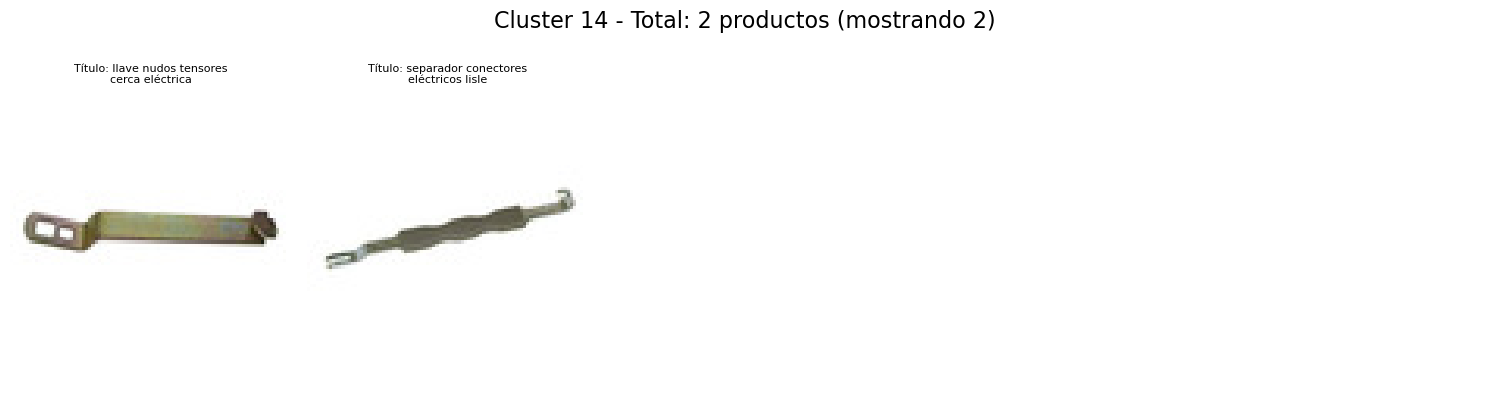


Cluster 15 - Mostrando 2 de 2 productos:


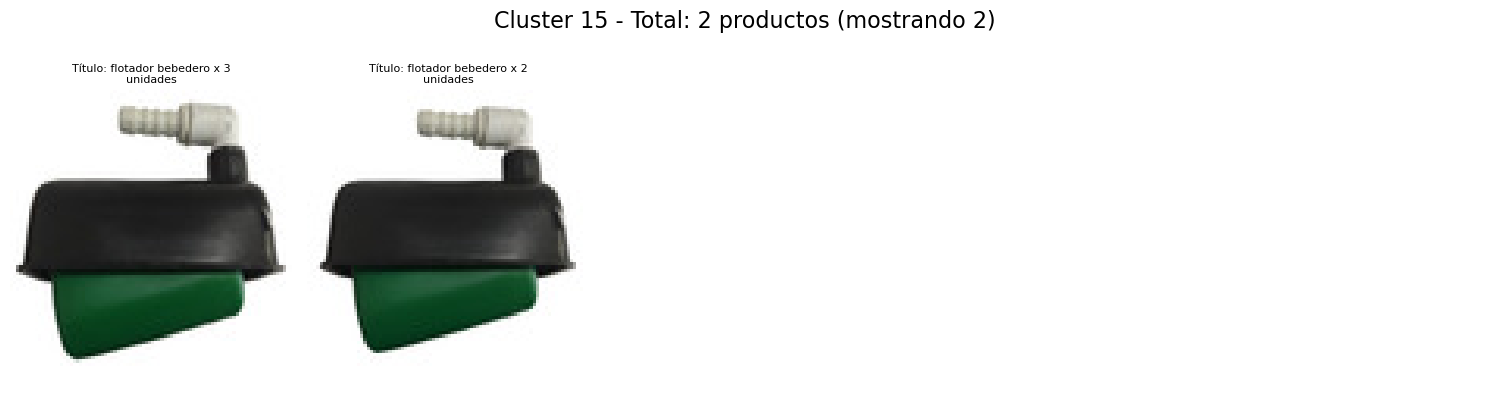


Cluster 30 - Mostrando 2 de 2 productos:


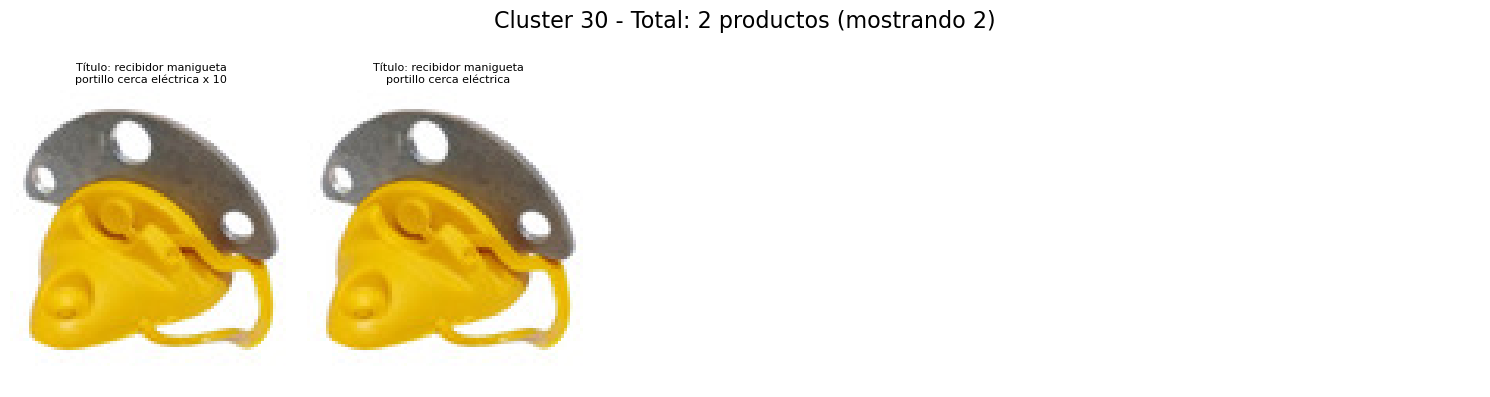


Cluster 32 - Mostrando 2 de 2 productos:


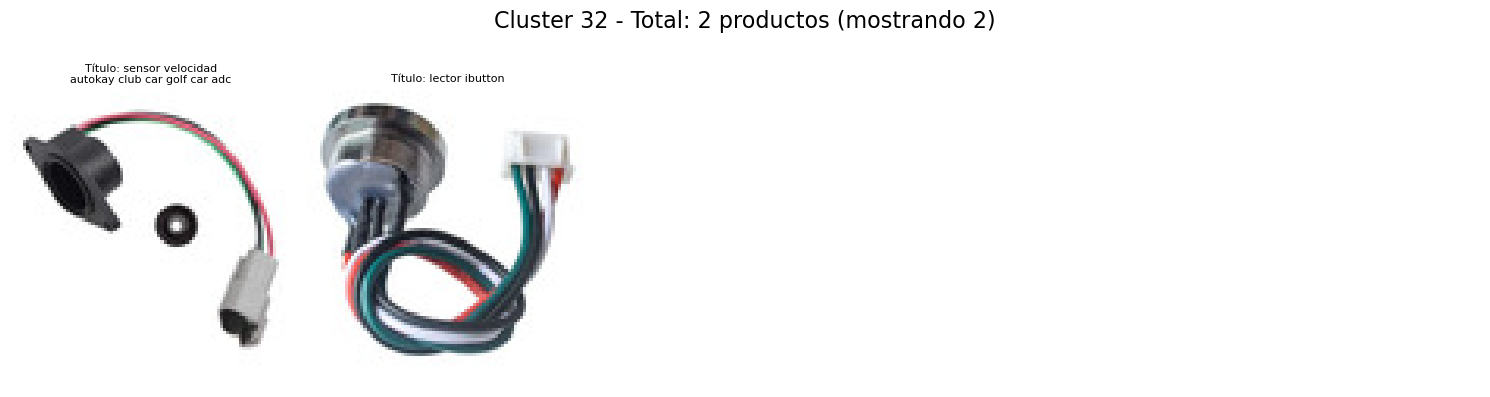


Cluster 34 - Mostrando 2 de 2 productos:


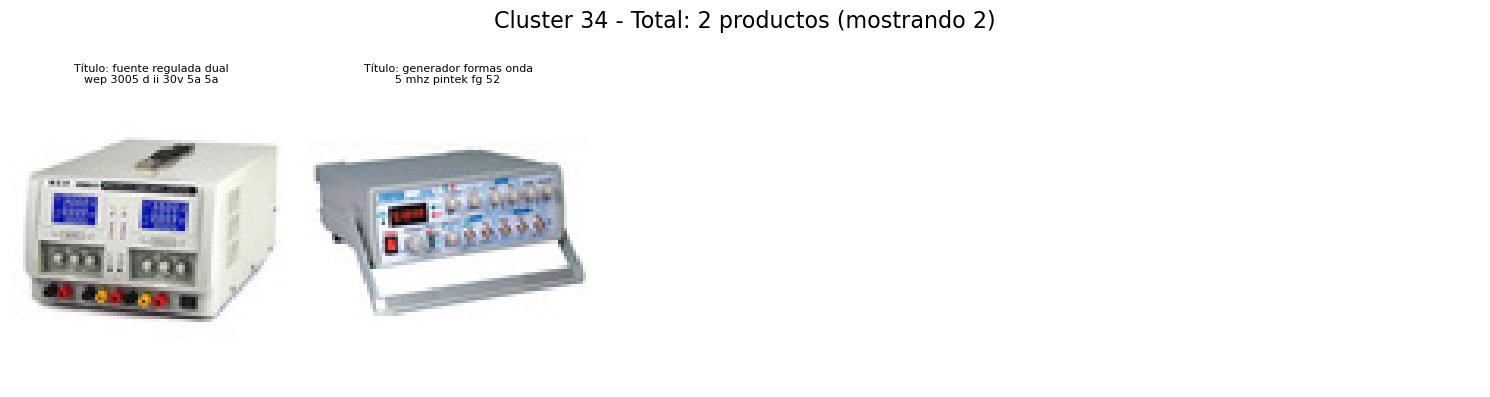


Cluster 33 - Mostrando 2 de 2 productos:


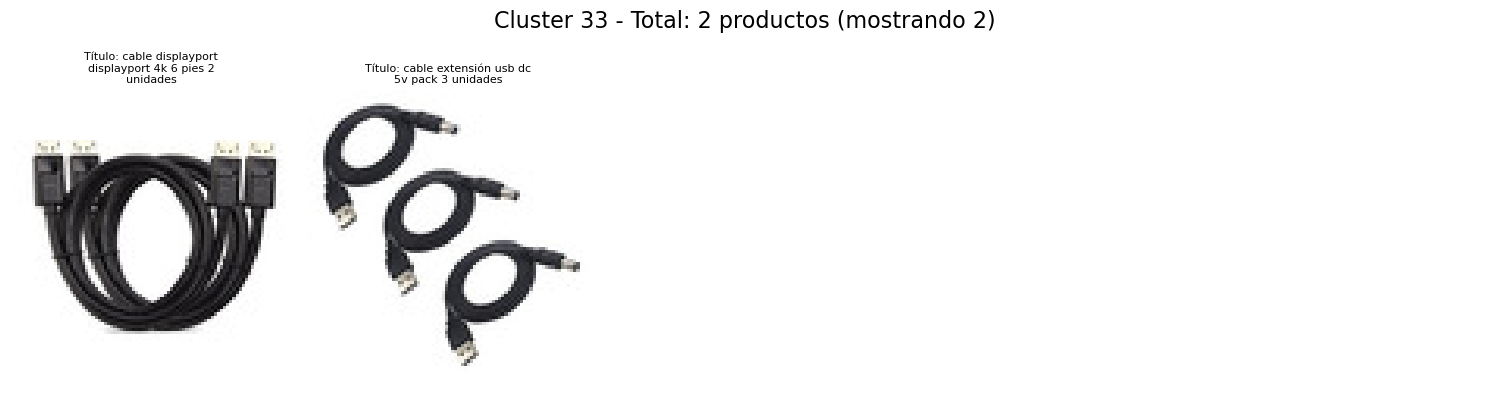


Cluster 27 - Mostrando 2 de 2 productos:


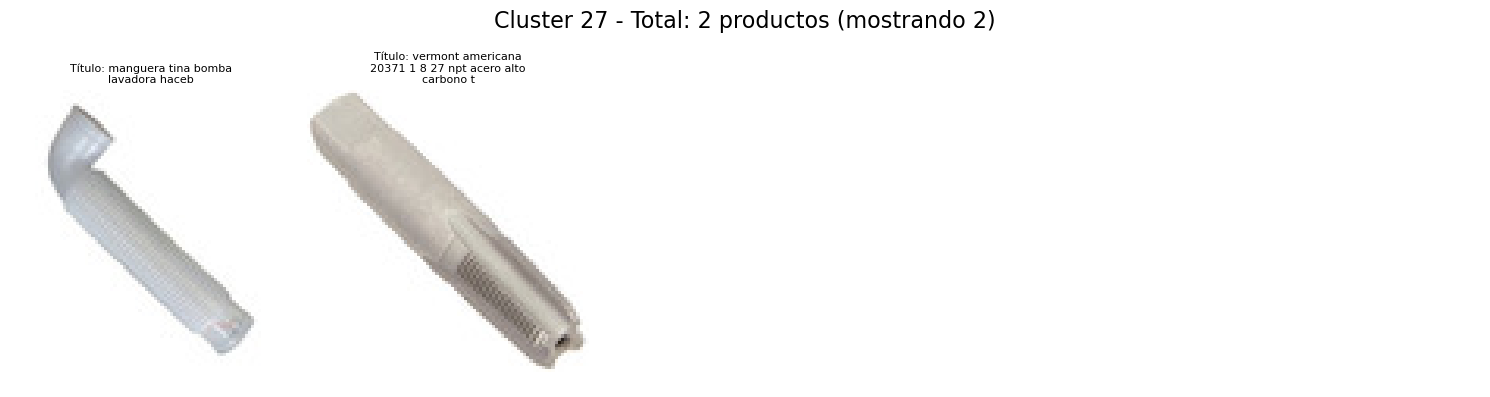


Cluster 28 - Mostrando 2 de 2 productos:


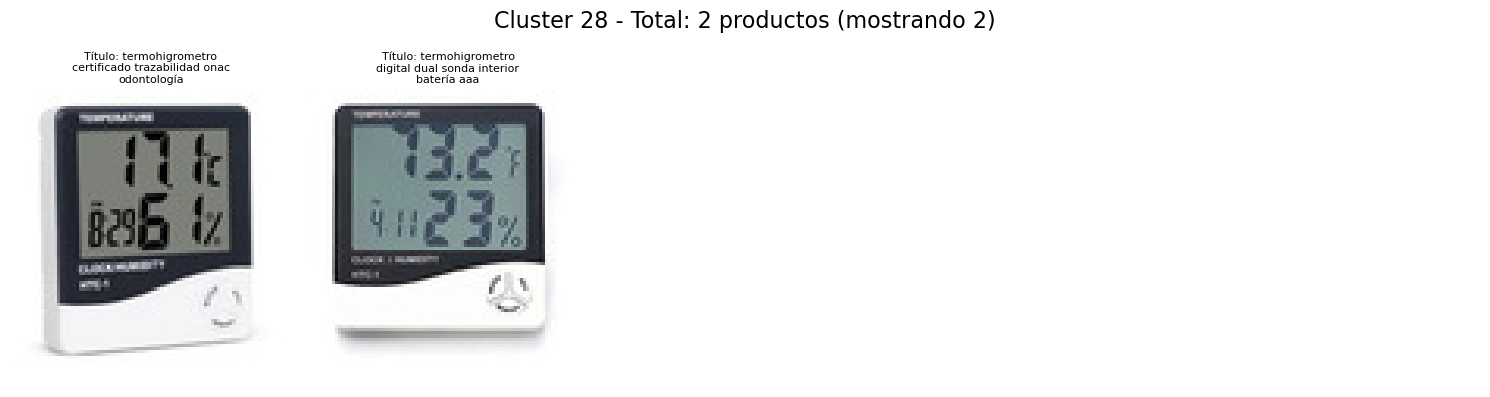


Cluster 29 - Mostrando 2 de 2 productos:


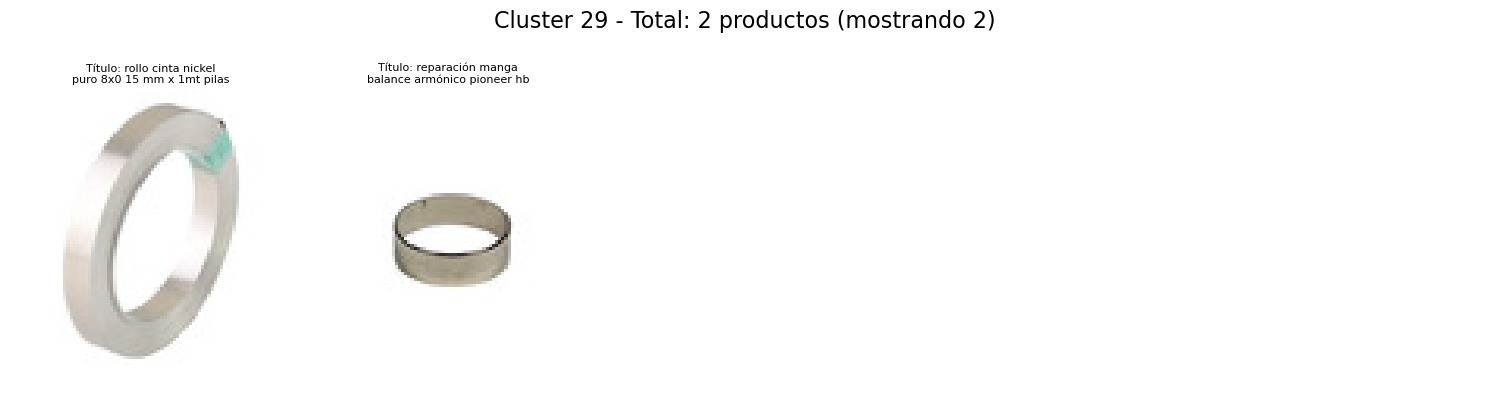


Cluster 25 - Mostrando 2 de 2 productos:


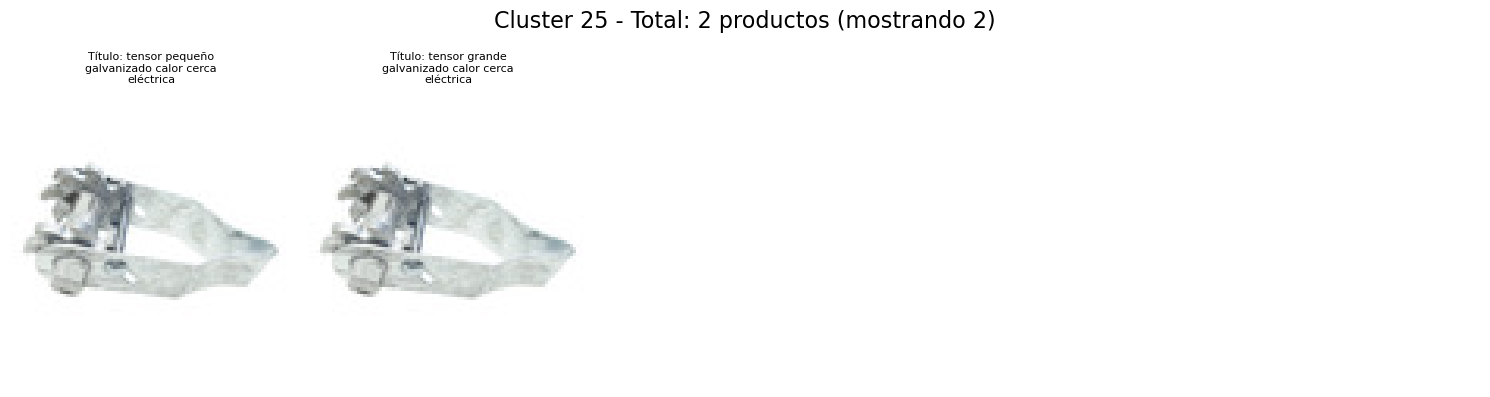


Cluster 39 - Mostrando 2 de 2 productos:


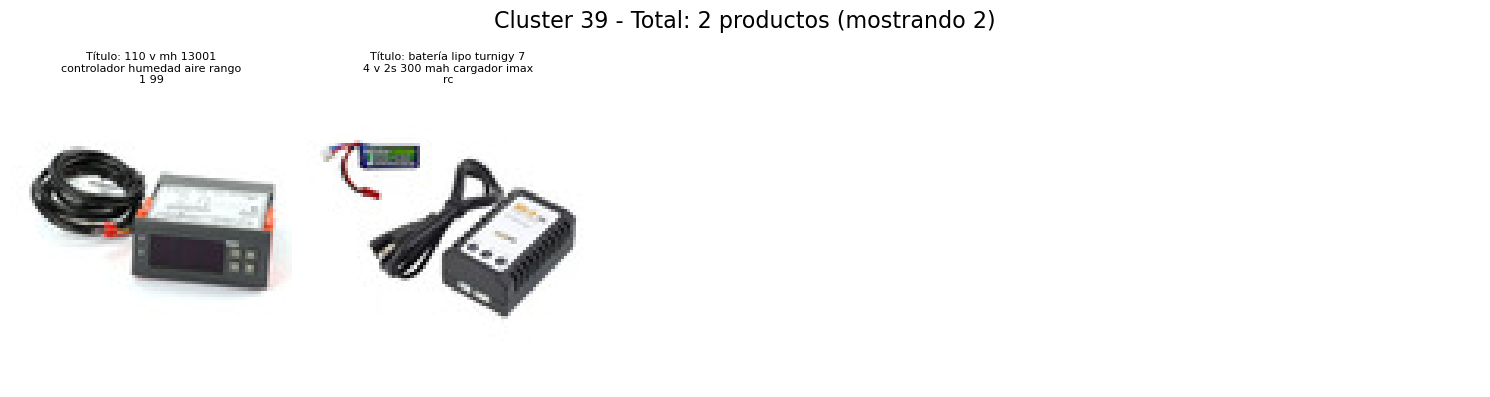


Cluster 38 - Mostrando 2 de 2 productos:


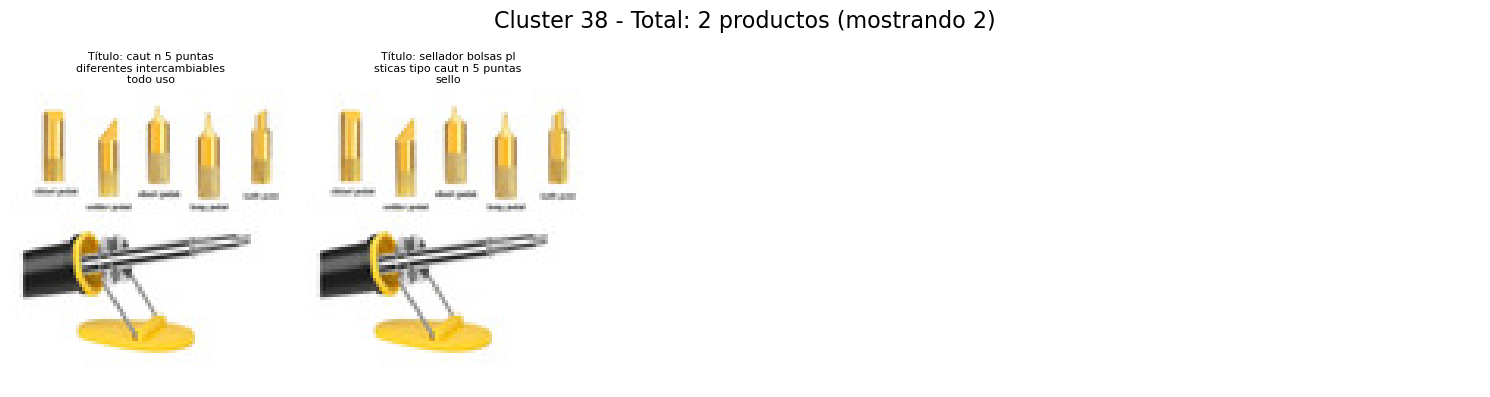


Cluster 36 - Mostrando 2 de 2 productos:


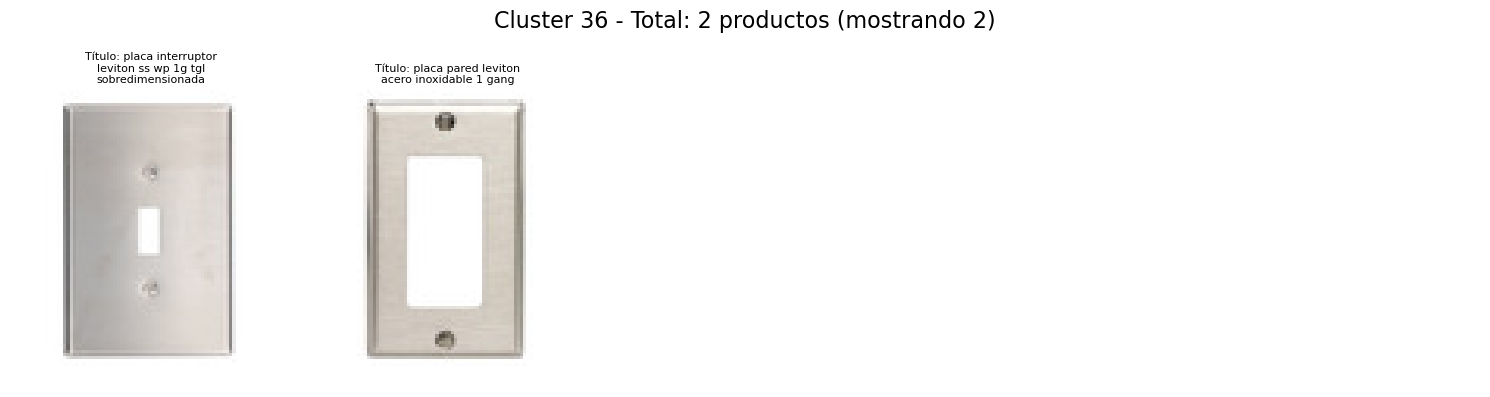


Cluster 35 - Mostrando 2 de 2 productos:


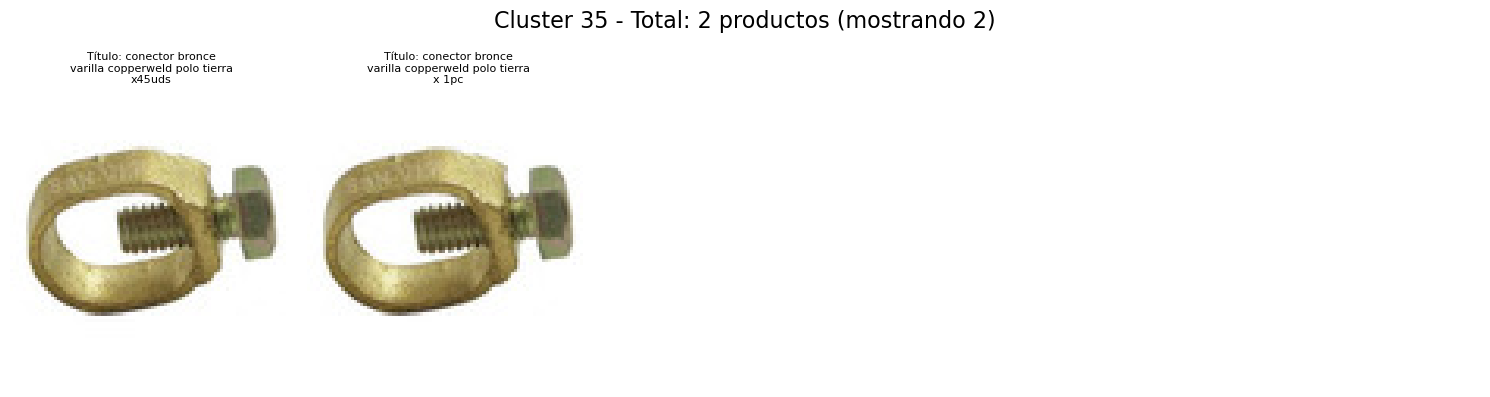


Cluster 42 - Mostrando 2 de 2 productos:


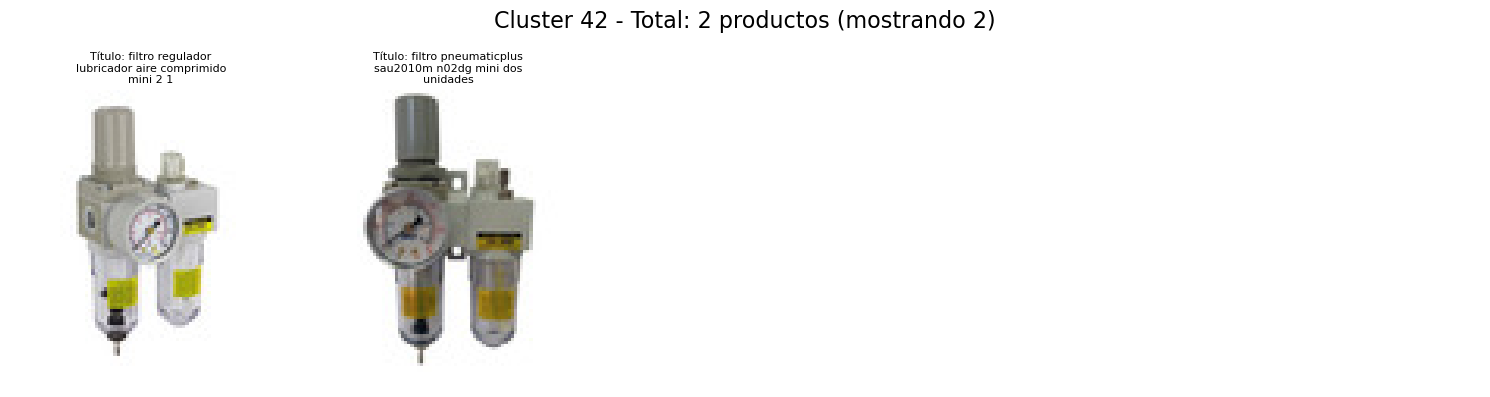


Cluster 45 - Mostrando 2 de 2 productos:


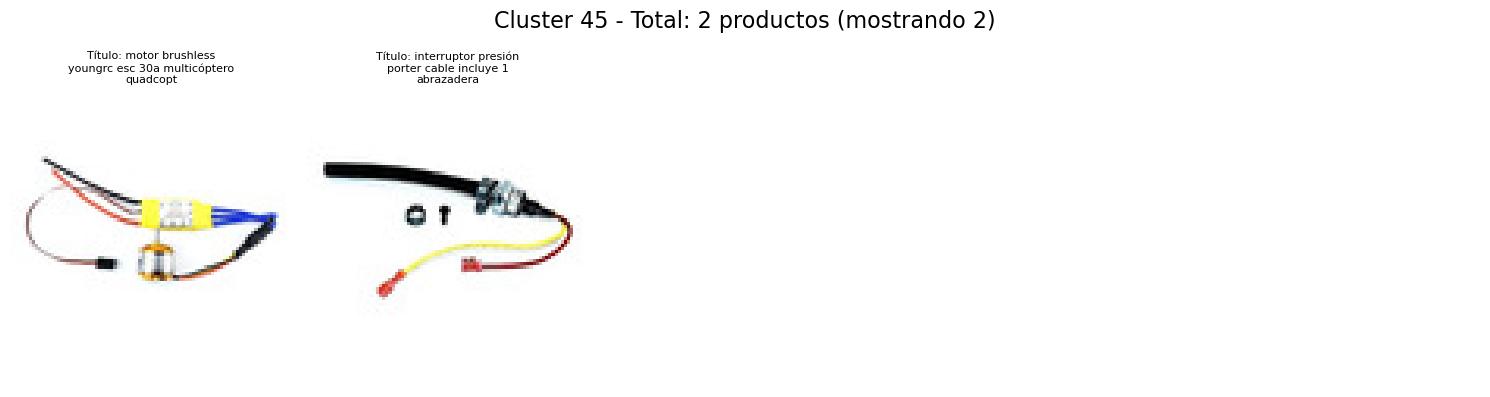


Cluster 46 - Mostrando 2 de 2 productos:


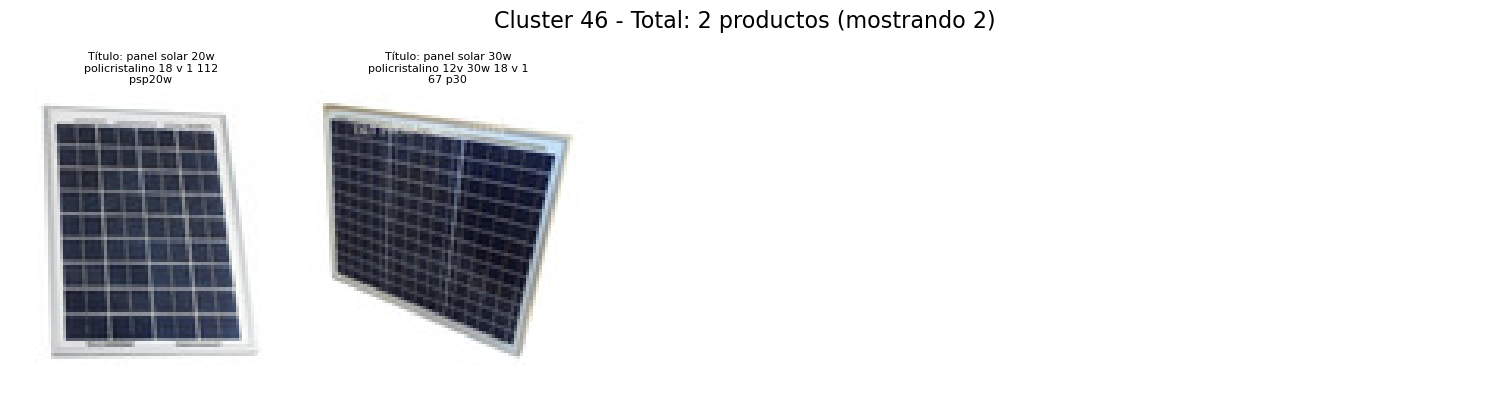


Cluster 40 - Mostrando 2 de 2 productos:


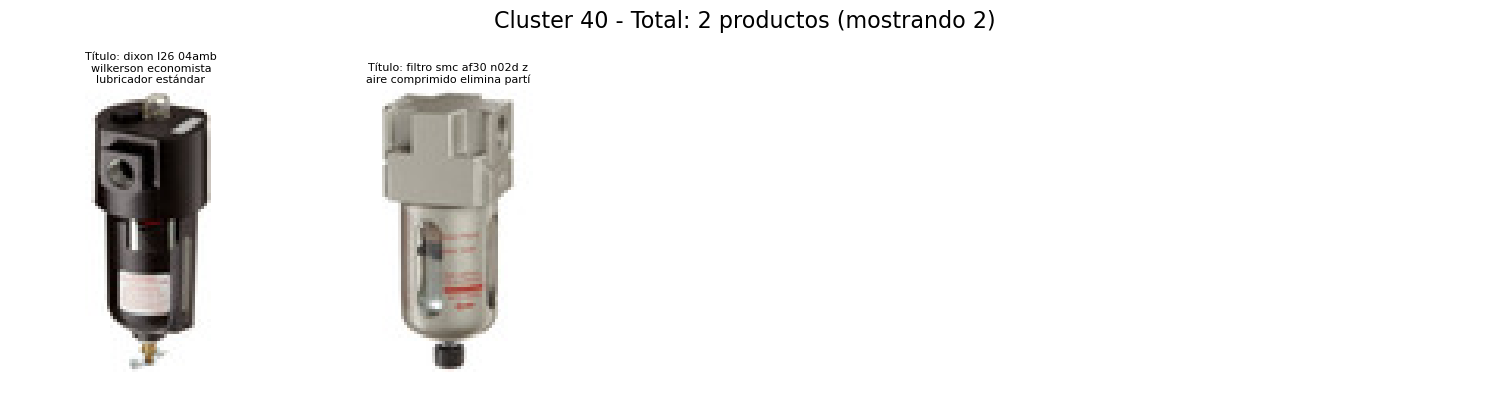


Cluster 47 - Mostrando 2 de 2 productos:


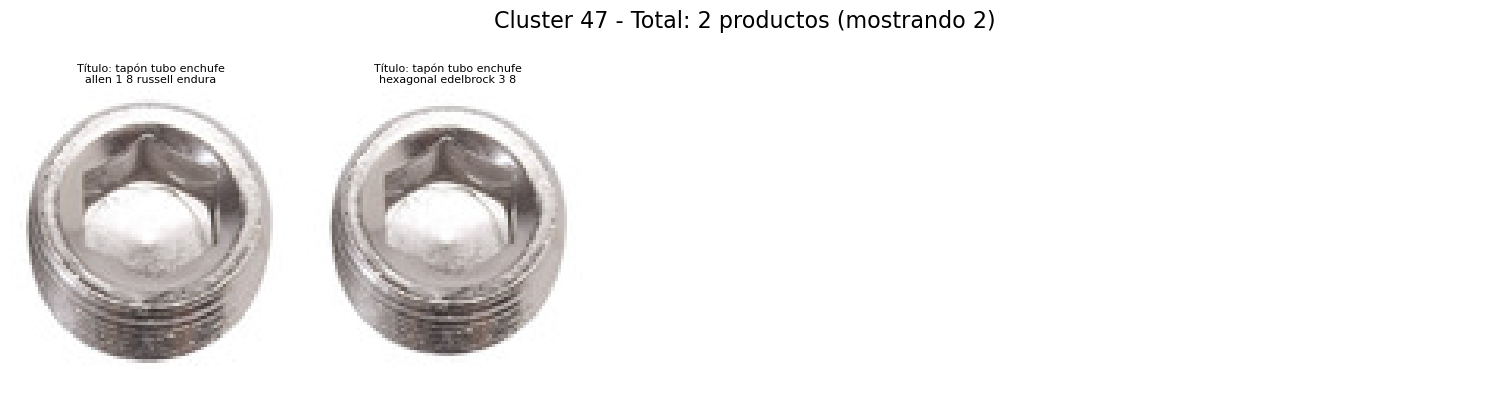


Cluster 48 - Mostrando 2 de 2 productos:


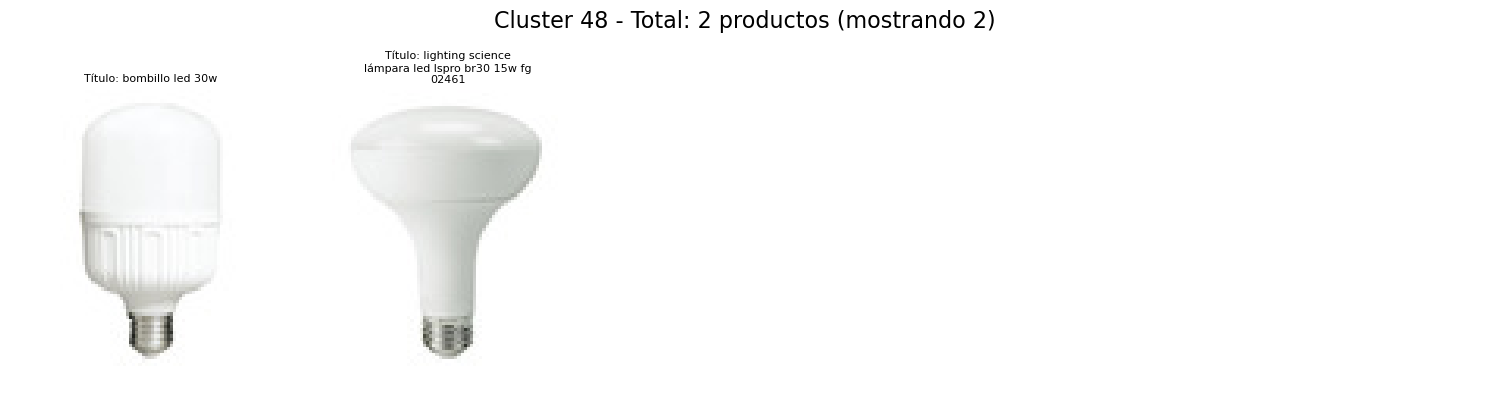


Cluster 50 - Mostrando 2 de 2 productos:


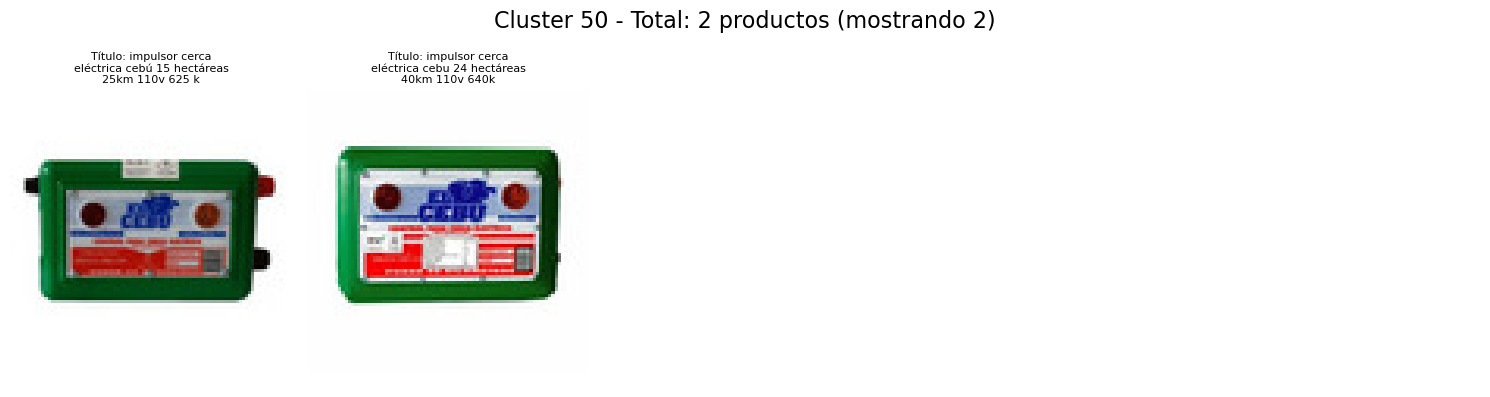


Cluster 49 - Mostrando 2 de 2 productos:


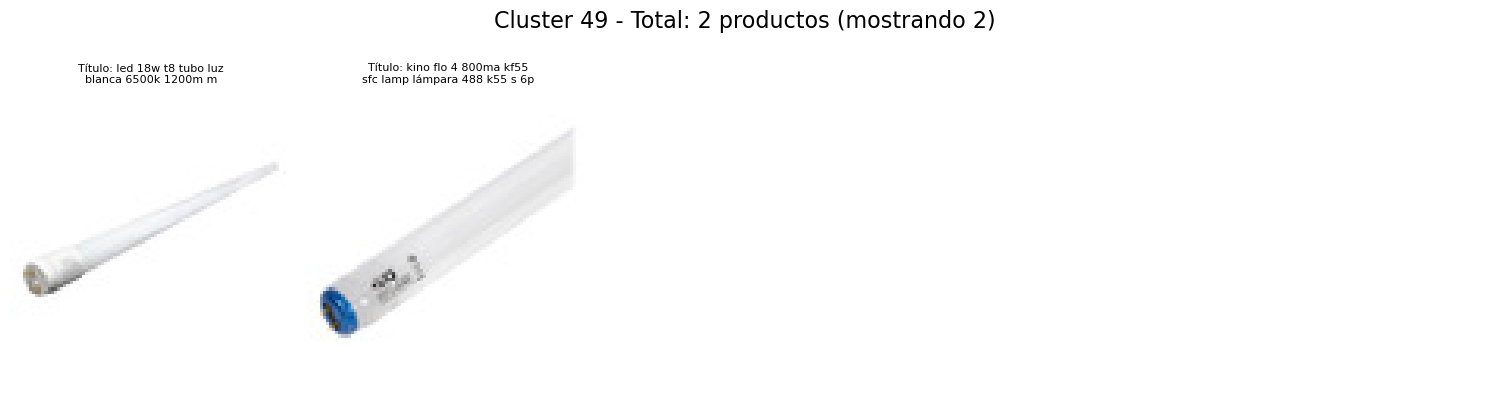


Cluster 51 - Mostrando 2 de 2 productos:


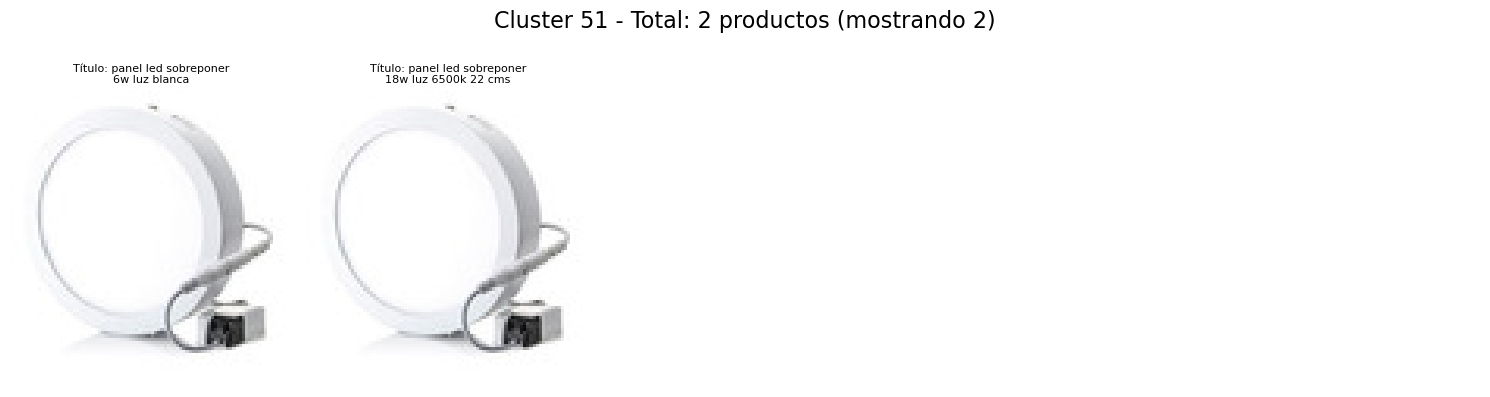


Cluster 52 - Mostrando 2 de 2 productos:


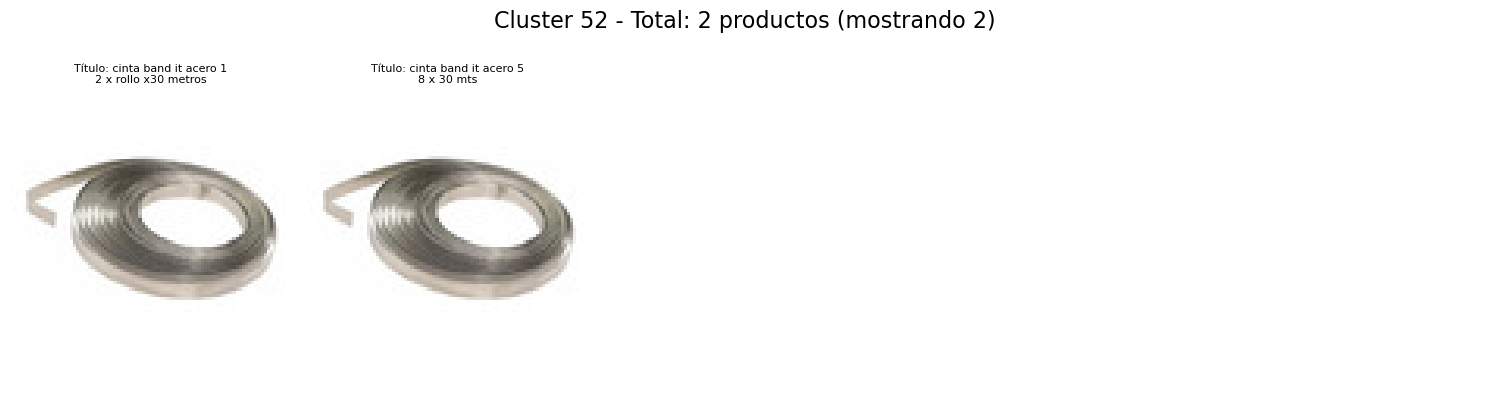


Cluster 54 - Mostrando 2 de 2 productos:


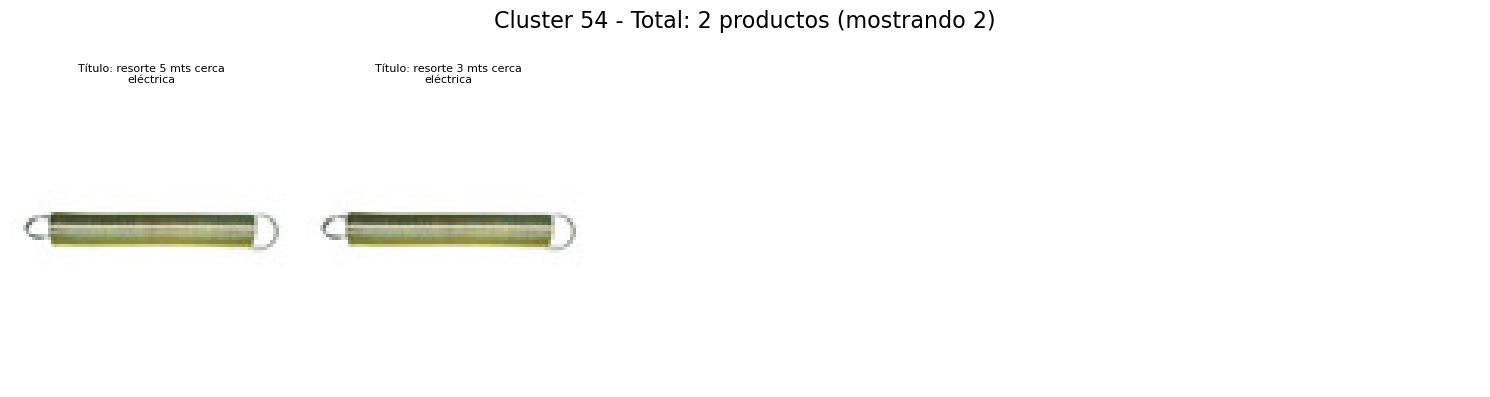


Cluster 55 - Mostrando 2 de 2 productos:


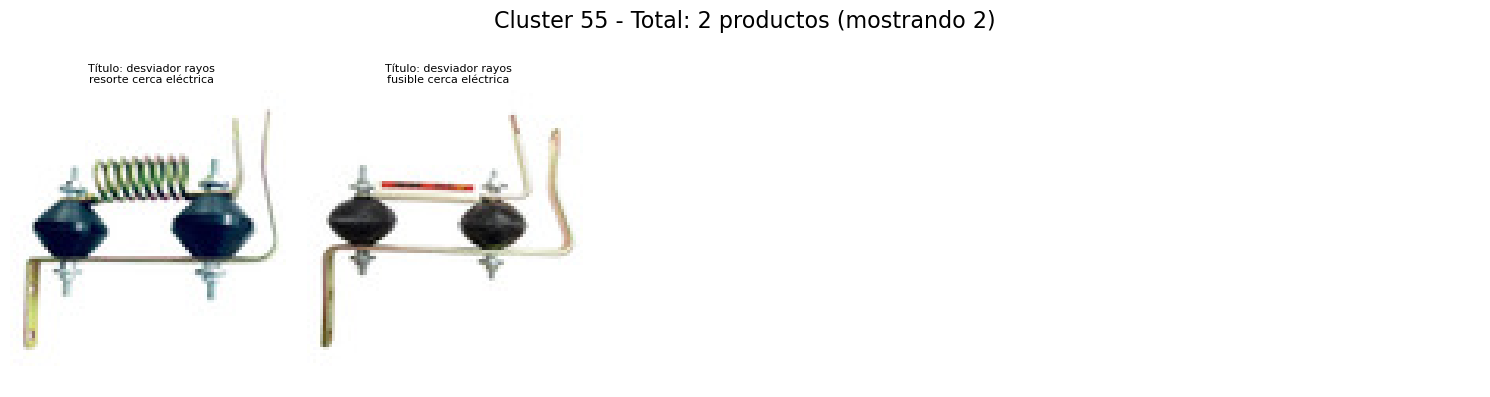

In [137]:

import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import numpy as np
from textwrap import wrap

# Obtener los 10 clusters más grandes
cluster_counts = outliers['new_cluster'].value_counts().head(60)
print("60 Clusters con más productos:")
print(cluster_counts)

# Configuración de la figura para subplots
for cluster_id in cluster_counts.index:
    cluster_data = outliers[outliers['new_cluster'] == cluster_id]
    num_products = min(len(cluster_data), 35)  # Limitar a 15 productos máximo
    print(f"\nCluster {cluster_id} - Mostrando {num_products} de {len(cluster_data)} productos:")

    # Determinar el número de filas y columnas dinámicamente
    num_cols = 5  # Máximo 5 columnas
    num_rows = (num_products + num_cols - 1) // num_cols  # Calcular filas necesarias
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 4))
    fig.suptitle(f"Cluster {cluster_id} - Total: {len(cluster_data)} productos (mostrando {num_products})", fontsize=16)

    # Aplanar los ejes para iterar fácilmente
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    # Mostrar imágenes y títulos de los productos
    for idx, (index, row) in enumerate(cluster_data.head(num_products).iterrows()):
        try:
            # Descargar y cargar la imagen
            response = requests.get(row['thumbnail'], timeout=10)
            response.raise_for_status()
            image = Image.open(BytesIO(response.content))

            # Mostrar la imagen en el subplot
            axes[idx].imshow(image)
            axes[idx].axis('off')
            # Título del producto, limitado a dos líneas
            title = "\n".join(wrap(f"Título: {row['title_std']}", width=30))
            axes[idx].set_title(title, fontsize=8, wrap=True)
        except Exception as e:
            axes[idx].axis('off')
            axes[idx].set_title("Imagen no disponible", fontsize=8)
        
    # Ocultar subplots sobrantes si hay menos productos que subplots
    for ax in axes[num_products:]:
        ax.axis('off')

    # Ajustar diseño del subplot
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar espacio para el título
    plt.show()



### **Explicación del Proceso de Clustering y Justificación del Modelo Final**

---

### **Fase 1: Clustering Inicial Basado en el Título del Producto**
En la primera etapa, se realizó un clustering basado únicamente en los **títulos de los productos** utilizando los embeddings generados con OpenAI. Esta decisión se tomó porque los títulos de los productos contienen información descriptiva clave que ayuda a agrupar productos similares.

1. **Modelo Utilizado**:
   - DBSCAN se empleó para identificar grupos naturales de productos similares, optimizando los parámetros `eps` y `min_samples`.

2. **Resultados del Clustering Inicial**:
   - **Número de clusters formados**: Variado según los parámetros.
   - **Noise Ratio**: Elevado, ya que una parte considerable de los productos no se agrupó en clusters debido a su naturaleza única o falta de información suficiente en los títulos.

3. **Limitación Identificada**:
   - Los productos etiquetados como `-1` (ruido) no pudieron ser agrupados adecuadamente debido a la falta de información contextual adicional, como imágenes, precios o marcas.

---

### **Fase 2: Agrupación de Outliers con Características Adicionales**
Para abordar las limitaciones del clustering inicial, se diseñó una estrategia para procesar los **outliers (`-1`)** identificados previamente. En esta segunda etapa:
1. **Características Adicionales Utilizadas**:
   - **Imágenes de los productos** (procesadas con CLIP) para capturar similitudes visuales.
   - **Precios** normalizados, para identificar productos dentro de rangos económicos similares.
   - **Marcas**, como un indicador importante en ciertos segmentos.
   - **GTIN**, si estaba disponible, para agregar una capa de información categórica.

2. **Modelo Utilizado**:
   - Nuevamente, se empleó DBSCAN con un enfoque optimizado para capturar la densidad en un espacio de características más rico.
   - Se realizaron pruebas de varias combinaciones de características para evaluar su impacto en los clusters y métricas.

3. **Resultados del Clustering de Outliers**:
   - Los productos etiquetados como ruido en el primer clustering ahora se agruparon en clusters más pequeños pero relevantes.
   - Se analizaron las métricas obtenidas para seleccionar la mejor configuración.

---

### **Justificación del Modelo Final**
El modelo final elegido (fila **28**) representa la combinación más sólida de características y parámetros para agrupar tanto los productos originales como los outliers, basándose en las siguientes métricas:

1. **Silhouette Score**: `0.50509`
   - Un puntaje que indica una buena separación entre los clusters formados, especialmente considerando la complejidad de los datos.

2. **Davies-Bouldin Score**: `0.741442`
   - Este puntaje refleja clusters compactos y razonablemente separados, lo que confirma la calidad del agrupamiento.

3. **Noise Ratio**: `0.799423`
   - Aunque un ruido cercano al 80% es elevado, fue tolerado debido a la naturaleza dispersa de los datos y la dificultad de agrupar ciertos productos únicos.

---

### **Impacto del Modelo en el Problema**
- **Productos Iniciales**: Agrupados de manera efectiva según la similitud de sus títulos.
- **Outliers**: Ahora forman clusters útiles basados en similitudes visuales, precios y marcas, lo que permite identificar productos únicos o difíciles de clasificar en la primera etapa.

---

### **Conclusión y Próximos Pasos**
El modelo seleccionado logra:
1. Maximizar la calidad de los clusters formados (con un Silhouette Score alto).
2. Reducir el número de productos no agrupados al incluir información adicional (imágenes, precios, etc.).
3. Proveer una base sólida para análisis posteriores, como personalización de resultados o recomendaciones.
